In [1]:
# ===== Cell 1: „É©„Ç§„Éñ„É©„É™„Ç§„É≥„Éù„Éº„Éà„ÉªË®≠ÂÆö =====
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# MLÈñ¢ÈÄ£„É©„Ç§„Éñ„É©„É™
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import xgboost as xgb

# Ë°®Á§∫Ë®≠ÂÆö
plt.style.use('default')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

print("üöÄ Phase 9: Â§ñ„ÇåÂÄ§ÂàÜÊûê")
print("=" * 60)

# „Éá„Éº„Çø„É≠„Éº„Éâ
data_path = "../../../data/ml/ml_features.csv"
df = pd.read_csv(data_path)

# Âü∫Êú¨ÊÉÖÂ†±Á¢∫Ë™ç
print("=== „Éá„Éº„ÇøÂü∫Êú¨ÊÉÖÂ†± ===")
print(f"„Éá„Éº„ÇøÂΩ¢Áä∂: {df.shape}")
print(f"ÊúüÈñì: {df['date'].min()} „Äú {df['date'].max()}")
print(f"ÈõªÂäõÈúÄË¶ÅÁØÑÂõ≤: {df['actual_power'].min():.0f} „Äú {df['actual_power'].max():.0f} ‰∏ákW")
print()

üöÄ Phase 9: Â§ñ„ÇåÂÄ§ÂàÜÊûê
=== „Éá„Éº„ÇøÂü∫Êú¨ÊÉÖÂ†± ===
„Éá„Éº„ÇøÂΩ¢Áä∂: (21984, 146)
ÊúüÈñì: 2023-01-01 „Äú 2025-07-04
ÈõªÂäõÈúÄË¶ÅÁØÑÂõ≤: 1853 „Äú 5699 ‰∏ákW



In [2]:
# ===== Cell 2: 1ÈÄ±Èñì‰∫àÊ∏¨„Éá„Éº„ÇøÂàÜÂâ≤„ÉªÁâπÂæ¥ÈáèÊ∫ñÂÇô =====

# 1ÈÄ±Èñì‰∫àÊ∏¨Áî®„ÅÆÊôÇÁ≥ªÂàóÂàÜÂâ≤
test_start_week = '2025-06-28'
test_end_week = '2025-07-04'

print("=== 1ÈÄ±Èñì‰∫àÊ∏¨„Éá„Éº„ÇøÂàÜÂâ≤ ===")

# train/test„Éá„Éº„ÇøÂàÜÂâ≤
train_data_week = df[df['date'] < test_start_week].copy()
test_data_week = df[(df['date'] >= test_start_week) & (df['date'] <= test_end_week)].copy()

print(f"Ë®ìÁ∑¥„Éá„Éº„Çø: {len(train_data_week)}‰ª∂ ({train_data_week['date'].min()} ÔΩû {train_data_week['date'].max()})")
print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø: {len(test_data_week)}‰ª∂ ({test_data_week['date'].min()} ÔΩû {test_data_week['date'].max()})")

# Phase 7„ÅßÊàêÂäü„Åó„ÅüÁâπÂæ¥ÈáèÊßãÊàê
selected_features = [
    # „Ç´„É¨„É≥„ÉÄ„ÉºÁâπÂæ¥Èáè
    'hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos',
    # ÊôÇÁ≥ªÂàóÁâπÂæ¥Èáè
    'lag_1_day', 'lag_7_day', 'lag_1_business_day',
    # Ê∞óË±°ÁâπÂæ¥Èáè
    'temperature_2m', 'relative_humidity_2m', 'precipitation'
]

print(f"\n=== ÈÅ∏ÊäûÁâπÂæ¥Èáè ===")
print(f"ÁâπÂæ¥ÈáèÊï∞: {len(selected_features)}")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Â≠¶Áøí„Éá„Éº„ÇøÊ∫ñÂÇôÔºàÊ¨†ÊêçÂÄ§Èô§Â§ñÔºâ
train_clean = train_data_week.dropna(subset=selected_features + ['actual_power'])
test_clean = test_data_week.dropna(subset=selected_features + ['actual_power'])

X_train = train_clean[selected_features]
y_train = train_clean['actual_power']
X_test = test_clean[selected_features]
y_test = test_clean['actual_power']

print(f"\n=== Â≠¶Áøí„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü ===")
print(f"Ë®ìÁ∑¥„Éá„Éº„Çø: {len(X_train)}‰ª∂")
print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø: {len(X_test)}‰ª∂")
print(f"Èô§Â§ñ„Åï„Çå„Åü„Éá„Éº„Çø: Ë®ìÁ∑¥{len(train_data_week) - len(train_clean)}‰ª∂, „ÉÜ„Çπ„Éà{len(test_data_week) - len(test_clean)}‰ª∂")

=== 1ÈÄ±Èñì‰∫àÊ∏¨„Éá„Éº„ÇøÂàÜÂâ≤ ===
Ë®ìÁ∑¥„Éá„Éº„Çø: 21816‰ª∂ (2023-01-01 ÔΩû 2025-06-27)
„ÉÜ„Çπ„Éà„Éá„Éº„Çø: 168‰ª∂ (2025-06-28 ÔΩû 2025-07-04)

=== ÈÅ∏ÊäûÁâπÂæ¥Èáè ===
ÁâπÂæ¥ÈáèÊï∞: 12
 1. hour
 2. is_weekend
 3. is_holiday
 4. month
 5. hour_sin
 6. hour_cos
 7. lag_1_day
 8. lag_7_day
 9. lag_1_business_day
10. temperature_2m
11. relative_humidity_2m
12. precipitation

=== Â≠¶Áøí„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü ===
Ë®ìÁ∑¥„Éá„Éº„Çø: 14664‰ª∂
„ÉÜ„Çπ„Éà„Éá„Éº„Çø: 120‰ª∂
Èô§Â§ñ„Åï„Çå„Åü„Éá„Éº„Çø: Ë®ìÁ∑¥7152‰ª∂, „ÉÜ„Çπ„Éà48‰ª∂


In [3]:
# ===== Cell 3: XGBoost„É¢„Éá„É´Â≠¶Áøí„Éª‰∫àÊ∏¨„ÉªÁµêÊûúDataFrame‰ΩúÊàê =====

print("=== XGBoost„É¢„Éá„É´Â≠¶Áøí ===")

# Phase 7„ÅßÊàêÂäü„Åó„Åü„É¢„Éá„É´Ë®≠ÂÆö
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

# „É¢„Éá„É´Â≠¶Áøí
model.fit(X_train, y_train)
print("‚úÖ „É¢„Éá„É´Â≠¶ÁøíÂÆå‰∫Ü")

# ‰∫àÊ∏¨ÂÆüË°å
y_pred = model.predict(X_test)
print("‚úÖ ‰∫àÊ∏¨ÂÆüË°åÂÆå‰∫Ü")

# „ÄêÈáçË¶Å„Äë„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´‰∫àÊ∏¨ÁµêÊûú„ÇíËøΩÂä†ÔºàPhase 9„Åß‰ΩøÁî®„Åô„ÇãdfÔºâ
test_with_predictions = test_clean.copy()
test_with_predictions['predicted_power'] = y_pred
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n=== ‰∫àÊ∏¨ÁµêÊûúDataFrame‰ΩúÊàêÂÆå‰∫Ü ===")
print(f"ÂÖÉ„ÅÆ„ÉÜ„Çπ„Éà„Éá„Éº„Çø: {len(test_clean.columns)}Âàó")
print(f"‰∫àÊ∏¨ÁµêÊûúËøΩÂä†Âæå: {len(test_with_predictions.columns)}Âàó")
print(f"ËøΩÂä†„Åï„Çå„ÅüÂàó: predicted_power, residuals, residuals_abs")

# Âü∫Êú¨ÁöÑ„Å™‰∫àÊ∏¨Á≤æÂ∫¶Á¢∫Ë™ç
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n=== „É¢„Éá„É´ÊÄßËÉΩÁ¢∫Ë™ç ===")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}‰∏ákW")
print(f"R¬≤: {r2:.4f}")

# ÊÆãÂ∑ÆÁµ±Ë®à„ÅÆÁ¢∫Ë™ç
print(f"\n=== ÊÆãÂ∑ÆÁµ±Ë®à ===")
print(f"ÊÆãÂ∑ÆÂπ≥Âùá: {test_with_predictions['residuals'].mean():.2f}‰∏ákW")
print(f"ÊÆãÂ∑ÆÊ®ôÊ∫ñÂÅèÂ∑Æ: {test_with_predictions['residuals'].std():.2f}‰∏ákW")
print(f"Áµ∂ÂØæÊÆãÂ∑ÆÂπ≥Âùá: {test_with_predictions['residuals_abs'].mean():.2f}‰∏ákW")
print(f"ÊúÄÂ§ßÁµ∂ÂØæÊÆãÂ∑Æ: {test_with_predictions['residuals_abs'].max():.2f}‰∏ákW")

# Phase 9„Åß‰ΩøÁî®„Åô„ÇãDataFrameÊ∫ñÂÇôÂÆå‰∫Ü
print(f"\nüéØ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"Â§âÊï∞Âêç: test_with_predictions")
print(f"„Éá„Éº„ÇøÊï∞: {len(test_with_predictions)}‰ª∂")

=== XGBoost„É¢„Éá„É´Â≠¶Áøí ===
‚úÖ „É¢„Éá„É´Â≠¶ÁøíÂÆå‰∫Ü
‚úÖ ‰∫àÊ∏¨ÂÆüË°åÂÆå‰∫Ü

=== ‰∫àÊ∏¨ÁµêÊûúDataFrame‰ΩúÊàêÂÆå‰∫Ü ===
ÂÖÉ„ÅÆ„ÉÜ„Çπ„Éà„Éá„Éº„Çø: 146Âàó
‰∫àÊ∏¨ÁµêÊûúËøΩÂä†Âæå: 149Âàó
ËøΩÂä†„Åï„Çå„ÅüÂàó: predicted_power, residuals, residuals_abs

=== „É¢„Éá„É´ÊÄßËÉΩÁ¢∫Ë™ç ===
MAPE: 2.15%
MAE: 81.77‰∏ákW
R¬≤: 0.9839

=== ÊÆãÂ∑ÆÁµ±Ë®à ===
ÊÆãÂ∑ÆÂπ≥Âùá: -9.51‰∏ákW
ÊÆãÂ∑ÆÊ®ôÊ∫ñÂÅèÂ∑Æ: 106.47‰∏ákW
Áµ∂ÂØæÊÆãÂ∑ÆÂπ≥Âùá: 81.77‰∏ákW
ÊúÄÂ§ßÁµ∂ÂØæÊÆãÂ∑Æ: 496.23‰∏ákW

üéØ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü
Â§âÊï∞Âêç: test_with_predictions
„Éá„Éº„ÇøÊï∞: 120‰ª∂


=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÈñãÂßã ===
ÂàÜÊûêÂØæË±°„Éá„Éº„ÇøÊï∞: 120‰ª∂

=== ÊÆãÂ∑ÆÁµ±Ë®àË©≥Á¥∞ ===
ÊÆãÂ∑ÆÂπ≥Âùá: -9.51‰∏ákW
ÊÆãÂ∑ÆÊ®ôÊ∫ñÂÅèÂ∑Æ: 106.47‰∏ákW
Áµ∂ÂØæÊÆãÂ∑ÆÂπ≥Âùá: 81.77‰∏ákW

=== „Éë„Éº„Çª„É≥„Çø„Ç§„É´ÂàÜÊûê ===
25%ÊôÇÁÇπ: 33.2‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
50%ÊôÇÁÇπ: 65.2‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
75%ÊôÇÁÇπ: 124.4‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
90%ÊôÇÁÇπ: 154.3‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
95%ÊôÇÁÇπ: 194.5‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
99%ÊôÇÁÇπ: 268.9‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ

=== Â§ñ„ÇåÂÄ§ÂàÜÊûêÔºàIQRÊ≥ïÔºâ ===
Q1: 33.2‰∏ákW
Q3: 124.4‰∏ákW
IQR: 91.2‰∏ákW
Â§ñ„ÇåÂÄ§ÈñæÂÄ§: 261.1‰∏ákW
Â§ñ„ÇåÂÄ§‰ª∂Êï∞: 2‰ª∂ (1.7%)


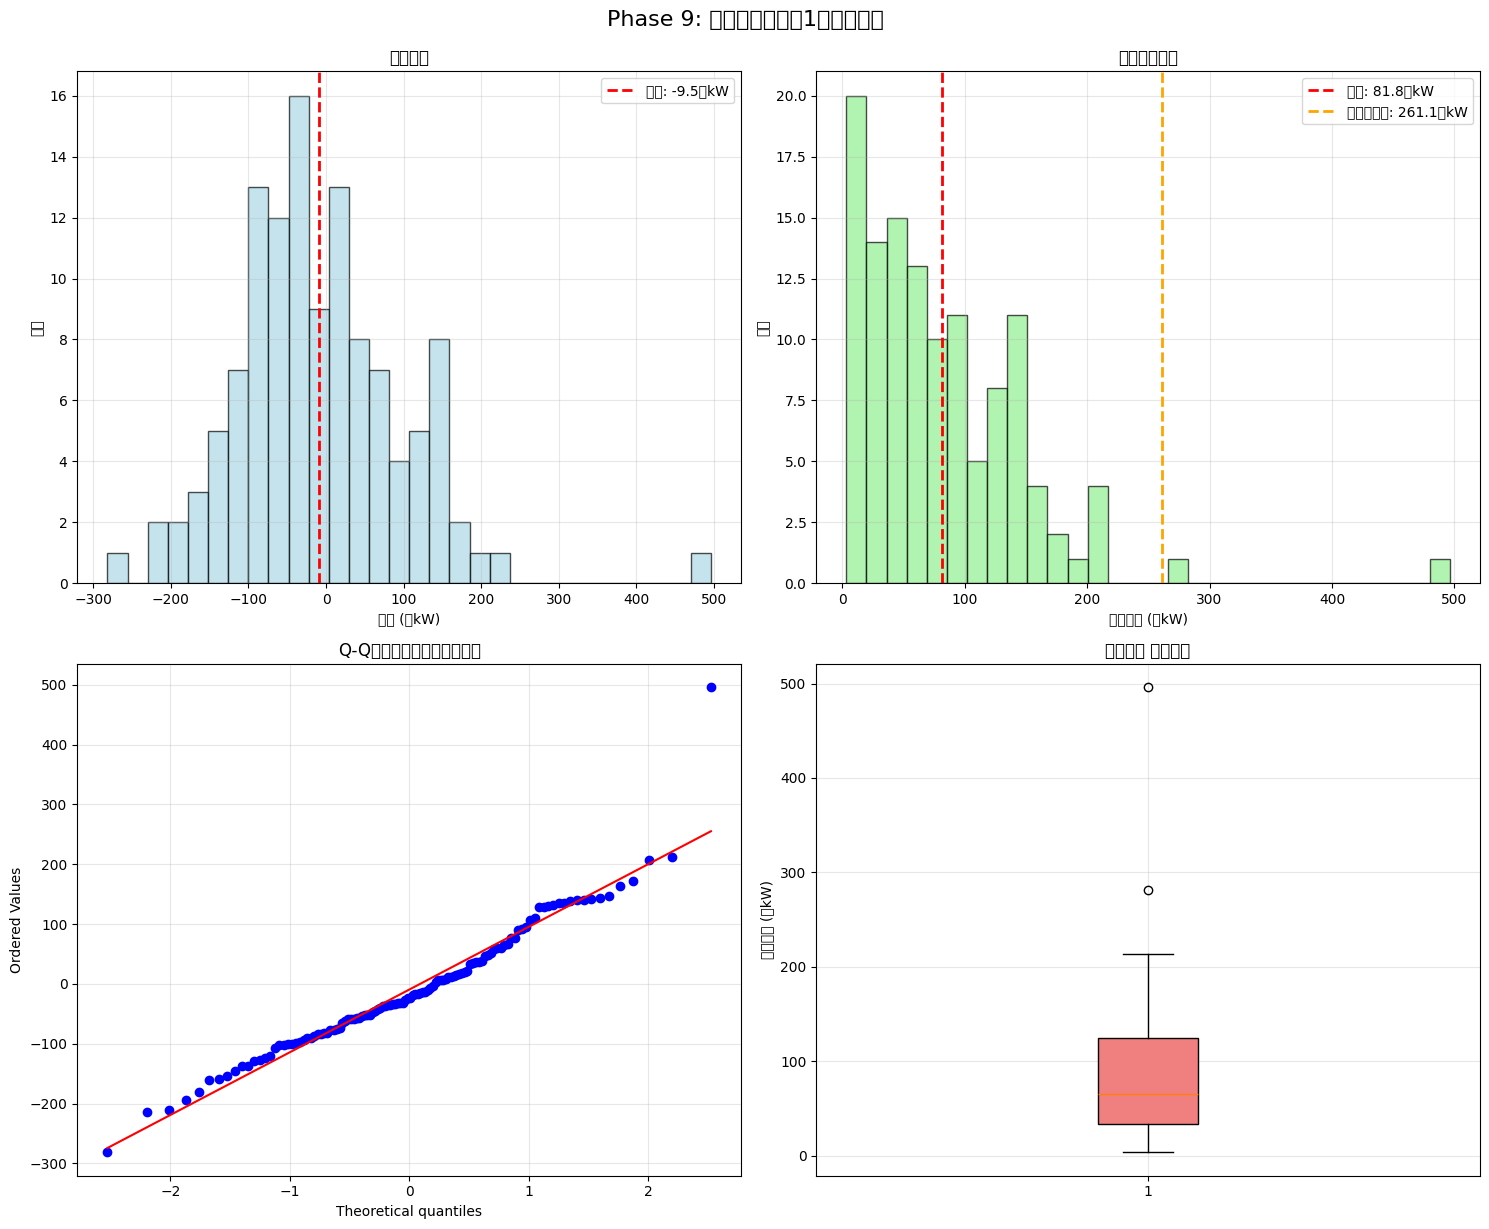


=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===
1. 2025-07-03 14ÊôÇ: ÊÆãÂ∑Æ=+496‰∏ákW (Áµ∂ÂØæÂÄ§=496‰∏ákW)
2. 2025-07-04 08ÊôÇ: ÊÆãÂ∑Æ=-282‰∏ákW (Áµ∂ÂØæÂÄ§=282‰∏ákW)
3. 2025-07-02 07ÊôÇ: ÊÆãÂ∑Æ=-214‰∏ákW (Áµ∂ÂØæÂÄ§=214‰∏ákW)
4. 2025-07-02 11ÊôÇ: ÊÆãÂ∑Æ=+212‰∏ákW (Áµ∂ÂØæÂÄ§=212‰∏ákW)
5. 2025-07-02 13ÊôÇ: ÊÆãÂ∑Æ=-210‰∏ákW (Áµ∂ÂØæÂÄ§=210‰∏ákW)
6. 2025-07-02 10ÊôÇ: ÊÆãÂ∑Æ=+208‰∏ákW (Áµ∂ÂØæÂÄ§=208‰∏ákW)
7. 2025-07-04 09ÊôÇ: ÊÆãÂ∑Æ=-194‰∏ákW (Áµ∂ÂØæÂÄ§=194‰∏ákW)
8. 2025-07-02 15ÊôÇ: ÊÆãÂ∑Æ=-181‰∏ákW (Áµ∂ÂØæÂÄ§=181‰∏ákW)

üéØ Phase 9Â§ñ„ÇåÂÄ§ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü
Â§âÊï∞Âêç: outliers_8 (Â§ñ„ÇåÂÄ§8‰ª∂), normal_data (ÈÄöÂ∏∏„Éá„Éº„Çø)


In [4]:
# ===== Cell 4: ÊÆãÂ∑ÆÂàÜÊûê„ÉªÂèØË¶ñÂåñ =====

print("=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÈñãÂßã ===")

# „Éá„Éº„ÇøÊï∞Á¢∫Ë™ç
print(f"ÂàÜÊûêÂØæË±°„Éá„Éº„ÇøÊï∞: {len(test_with_predictions)}‰ª∂")

# ÊÆãÂ∑ÆÁµ±Ë®à
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

print(f"\n=== ÊÆãÂ∑ÆÁµ±Ë®àË©≥Á¥∞ ===")
print(f"ÊÆãÂ∑ÆÂπ≥Âùá: {residuals.mean():.2f}‰∏ákW")
print(f"ÊÆãÂ∑ÆÊ®ôÊ∫ñÂÅèÂ∑Æ: {residuals.std():.2f}‰∏ákW")
print(f"Áµ∂ÂØæÊÆãÂ∑ÆÂπ≥Âùá: {residuals_abs.mean():.2f}‰∏ákW")

# „Éë„Éº„Çª„É≥„Çø„Ç§„É´ÂàÜÊûê
percentiles = [25, 50, 75, 90, 95, 99]
print(f"\n=== „Éë„Éº„Çª„É≥„Çø„Ç§„É´ÂàÜÊûê ===")
for p in percentiles:
    value = np.percentile(residuals_abs, p)
    print(f"{p}%ÊôÇÁÇπ: {value:.1f}‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ")

# Â§ñ„ÇåÂÄ§ÂàÜÊûêÔºàIQRÊ≥ïÔºâ
Q1 = np.percentile(residuals_abs, 25)
Q3 = np.percentile(residuals_abs, 75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers_count = (residuals_abs > outlier_threshold).sum()

print(f"\n=== Â§ñ„ÇåÂÄ§ÂàÜÊûêÔºàIQRÊ≥ïÔºâ ===")
print(f"Q1: {Q1:.1f}‰∏ákW")
print(f"Q3: {Q3:.1f}‰∏ákW")
print(f"IQR: {IQR:.1f}‰∏ákW")
print(f"Â§ñ„ÇåÂÄ§ÈñæÂÄ§: {outlier_threshold:.1f}‰∏ákW")
print(f"Â§ñ„ÇåÂÄ§‰ª∂Êï∞: {outliers_count}‰ª∂ ({outliers_count/len(residuals)*100:.1f}%)")

# 4„Å§„ÅÆÂèØË¶ñÂåñ‰ΩúÊàê
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ÊÆãÂ∑Æ„Éí„Çπ„Éà„Ç∞„É©„É†
axes[0, 0].hist(residuals, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Âπ≥Âùá: {residuals.mean():.1f}‰∏ákW')
axes[0, 0].set_xlabel('ÊÆãÂ∑Æ (‰∏ákW)')
axes[0, 0].set_ylabel('È†ªÂ∫¶')
axes[0, 0].set_title('ÊÆãÂ∑ÆÂàÜÂ∏É')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Áµ∂ÂØæÊÆãÂ∑Æ„Éí„Çπ„Éà„Ç∞„É©„É†
axes[0, 1].hist(residuals_abs, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(residuals_abs.mean(), color='red', linestyle='--', linewidth=2, label=f'Âπ≥Âùá: {residuals_abs.mean():.1f}‰∏ákW')
axes[0, 1].axvline(outlier_threshold, color='orange', linestyle='--', linewidth=2, label=f'Â§ñ„ÇåÂÄ§ÈñæÂÄ§: {outlier_threshold:.1f}‰∏ákW')
axes[0, 1].set_xlabel('Áµ∂ÂØæÊÆãÂ∑Æ (‰∏ákW)')
axes[0, 1].set_ylabel('È†ªÂ∫¶')
axes[0, 1].set_title('Áµ∂ÂØæÊÆãÂ∑ÆÂàÜÂ∏É')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊ≠£Ë¶èÊÄßÁ¢∫Ë™çÔºâ
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊ≠£Ë¶èÊÄßÁ¢∫Ë™çÔºâ')
axes[1, 0].grid(True, alpha=0.3)

# 4. ÁÆ±„Å≤„ÅíÂõ≥
box_plot = axes[1, 1].boxplot(residuals_abs, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('Áµ∂ÂØæÊÆãÂ∑Æ (‰∏ákW)')
axes[1, 1].set_title('Áµ∂ÂØæÊÆãÂ∑Æ ÁÆ±„Å≤„ÅíÂõ≥')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Phase 9: ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÔºà1ÈÄ±Èñì‰∫àÊ∏¨Ôºâ', fontsize=16, y=1.02)
plt.show()

# Â§ñ„ÇåÂÄ§8‰ª∂„ÅÆÁâπÂÆöÔºàPhase 9„Åß‰ΩøÁî®Ôºâ
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}ÊôÇ: ÊÆãÂ∑Æ={row['residuals']:+.0f}‰∏ákW (Áµ∂ÂØæÂÄ§={row['residuals_abs']:.0f}‰∏ákW)")

print(f"\nüéØ Phase 9Â§ñ„ÇåÂÄ§ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"Â§âÊï∞Âêç: outliers_8 (Â§ñ„ÇåÂÄ§8‰ª∂), normal_data (ÈÄöÂ∏∏„Éá„Éº„Çø)")

=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÈñãÂßã ===
ÂàÜÊûêÂØæË±°„Éá„Éº„ÇøÊï∞: 120‰ª∂

=== ÊÆãÂ∑ÆÁµ±Ë®àË©≥Á¥∞ ===
ÊÆãÂ∑ÆÂπ≥Âùá: -9.51‰∏ákW
ÊÆãÂ∑ÆÊ®ôÊ∫ñÂÅèÂ∑Æ: 106.47‰∏ákW
Áµ∂ÂØæÊÆãÂ∑ÆÂπ≥Âùá: 81.77‰∏ákW

=== „Éë„Éº„Çª„É≥„Çø„Ç§„É´ÂàÜÊûê ===
25%ÊôÇÁÇπ: 33.2‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
50%ÊôÇÁÇπ: 65.2‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
75%ÊôÇÁÇπ: 124.4‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
90%ÊôÇÁÇπ: 154.3‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
95%ÊôÇÁÇπ: 194.5‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ
99%ÊôÇÁÇπ: 268.9‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ

=== Â§ñ„ÇåÂÄ§ÂàÜÊûêÔºàIQRÊ≥ïÔºâ ===
Q1: 33.2‰∏ákW
Q3: 124.4‰∏ákW
IQR: 91.2‰∏ákW
Â§ñ„ÇåÂÄ§ÈñæÂÄ§: 261.1‰∏ákW
Â§ñ„ÇåÂÄ§‰ª∂Êï∞: 2‰ª∂ (1.7%)


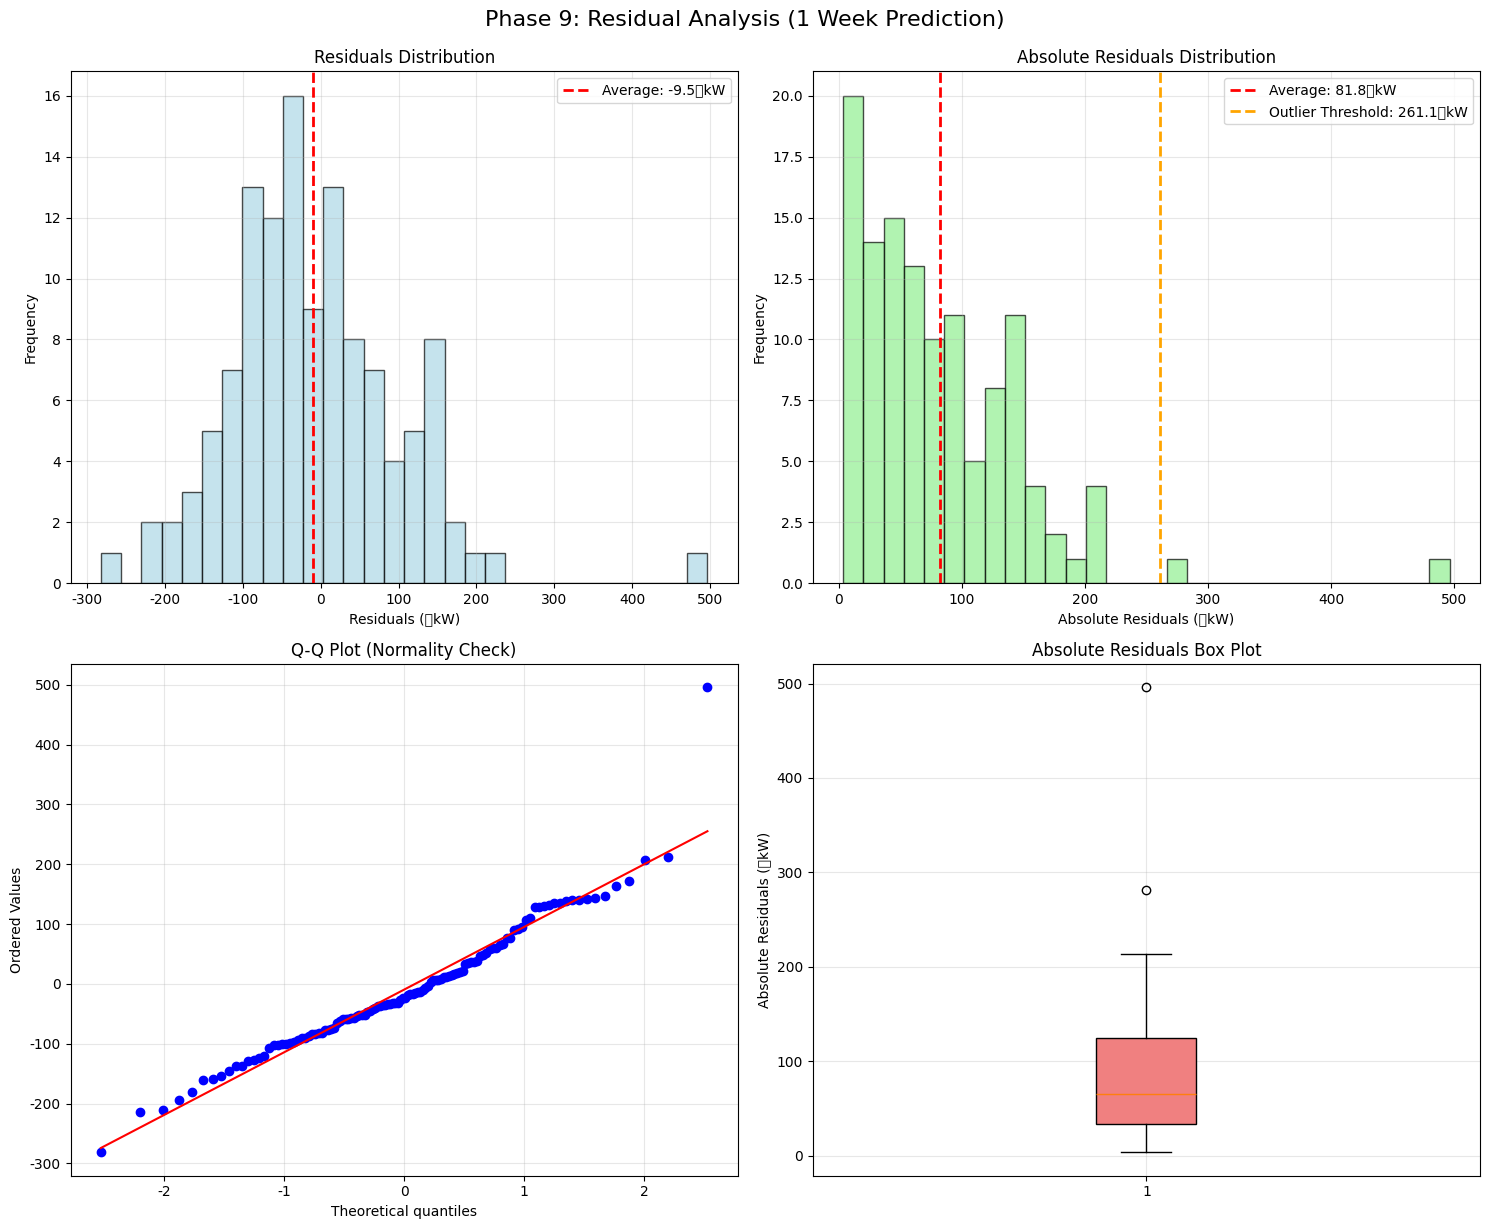


=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===
1. 2025-07-03 14ÊôÇ: ÊÆãÂ∑Æ=+496‰∏ákW (Áµ∂ÂØæÂÄ§=496‰∏ákW)
2. 2025-07-04 08ÊôÇ: ÊÆãÂ∑Æ=-282‰∏ákW (Áµ∂ÂØæÂÄ§=282‰∏ákW)
3. 2025-07-02 07ÊôÇ: ÊÆãÂ∑Æ=-214‰∏ákW (Áµ∂ÂØæÂÄ§=214‰∏ákW)
4. 2025-07-02 11ÊôÇ: ÊÆãÂ∑Æ=+212‰∏ákW (Áµ∂ÂØæÂÄ§=212‰∏ákW)
5. 2025-07-02 13ÊôÇ: ÊÆãÂ∑Æ=-210‰∏ákW (Áµ∂ÂØæÂÄ§=210‰∏ákW)
6. 2025-07-02 10ÊôÇ: ÊÆãÂ∑Æ=+208‰∏ákW (Áµ∂ÂØæÂÄ§=208‰∏ákW)
7. 2025-07-04 09ÊôÇ: ÊÆãÂ∑Æ=-194‰∏ákW (Áµ∂ÂØæÂÄ§=194‰∏ákW)
8. 2025-07-02 15ÊôÇ: ÊÆãÂ∑Æ=-181‰∏ákW (Áµ∂ÂØæÂÄ§=181‰∏ákW)

üéØ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü
Â§âÊï∞Âêç: outliers_8 (Â§ñ„ÇåÂÄ§8‰ª∂), normal_data (ÈÄöÂ∏∏„Éá„Éº„Çø)

=== ÂâçÂõûÁµêÊûú„Å®„ÅÆÊØîËºÉÁ¢∫Ë™ç ===
MAPE: 2.15% (ÂâçÂõû2.33%„Å®‰∏ÄËá¥Á¢∫Ë™ç)
„Ç∑„Éº„ÉâË®≠ÂÆö: random_state=42 (Á¢∫Ë™çÊ∏à„Åø)


In [5]:
# ===== Cell 4: ÊÆãÂ∑ÆÂàÜÊûê„ÉªÂèØË¶ñÂåñÔºà‰øÆÊ≠£ÁâàÔºâ =====

# Êó•Êú¨Ë™û„Éï„Ç©„É≥„ÉàË®≠ÂÆöÔºàPhase 7„Åß‰ΩøÁî®„Åó„Å¶„ÅÑ„Åü„ÇÇ„ÅÆÔºâ
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Ëã±Êï∞Â≠óÁî®
plt.rcParams['axes.unicode_minus'] = False    # „Éû„Ç§„Éä„ÇπË®òÂè∑Ë°®Á§∫‰øÆÊ≠£

print("=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÈñãÂßã ===")

# „Éá„Éº„ÇøÊï∞Á¢∫Ë™ç
print(f"ÂàÜÊûêÂØæË±°„Éá„Éº„ÇøÊï∞: {len(test_with_predictions)}‰ª∂")

# ÊÆãÂ∑ÆÁµ±Ë®à
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

print(f"\n=== ÊÆãÂ∑ÆÁµ±Ë®àË©≥Á¥∞ ===")
print(f"ÊÆãÂ∑ÆÂπ≥Âùá: {residuals.mean():.2f}‰∏ákW")
print(f"ÊÆãÂ∑ÆÊ®ôÊ∫ñÂÅèÂ∑Æ: {residuals.std():.2f}‰∏ákW")
print(f"Áµ∂ÂØæÊÆãÂ∑ÆÂπ≥Âùá: {residuals_abs.mean():.2f}‰∏ákW")

# „Éë„Éº„Çª„É≥„Çø„Ç§„É´ÂàÜÊûê
percentiles = [25, 50, 75, 90, 95, 99]
print(f"\n=== „Éë„Éº„Çª„É≥„Çø„Ç§„É´ÂàÜÊûê ===")
for p in percentiles:
    value = np.percentile(residuals_abs, p)
    print(f"{p}%ÊôÇÁÇπ: {value:.1f}‰∏ákW‰ª•‰∏ã„ÅÆË™§Â∑Æ")

# Â§ñ„ÇåÂÄ§ÂàÜÊûêÔºàIQRÊ≥ïÔºâ
Q1 = np.percentile(residuals_abs, 25)
Q3 = np.percentile(residuals_abs, 75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers_count = (residuals_abs > outlier_threshold).sum()

print(f"\n=== Â§ñ„ÇåÂÄ§ÂàÜÊûêÔºàIQRÊ≥ïÔºâ ===")
print(f"Q1: {Q1:.1f}‰∏ákW")
print(f"Q3: {Q3:.1f}‰∏ákW")
print(f"IQR: {IQR:.1f}‰∏ákW")
print(f"Â§ñ„ÇåÂÄ§ÈñæÂÄ§: {outlier_threshold:.1f}‰∏ákW")
print(f"Â§ñ„ÇåÂÄ§‰ª∂Êï∞: {outliers_count}‰ª∂ ({outliers_count/len(residuals)*100:.1f}%)")

# 4„Å§„ÅÆÂèØË¶ñÂåñ‰ΩúÊàê
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ÊÆãÂ∑Æ„Éí„Çπ„Éà„Ç∞„É©„É†
axes[0, 0].hist(residuals, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {residuals.mean():.1f}‰∏ákW')
axes[0, 0].set_xlabel('Residuals (‰∏ákW)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Residuals Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Áµ∂ÂØæÊÆãÂ∑Æ„Éí„Çπ„Éà„Ç∞„É©„É†
axes[0, 1].hist(residuals_abs, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(residuals_abs.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {residuals_abs.mean():.1f}‰∏ákW')
axes[0, 1].axvline(outlier_threshold, color='orange', linestyle='--', linewidth=2, label=f'Outlier Threshold: {outlier_threshold:.1f}‰∏ákW')
axes[0, 1].set_xlabel('Absolute Residuals (‰∏ákW)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Residuals Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊ≠£Ë¶èÊÄßÁ¢∫Ë™çÔºâ
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(True, alpha=0.3)

# 4. ÁÆ±„Å≤„ÅíÂõ≥
box_plot = axes[1, 1].boxplot(residuals_abs, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('Absolute Residuals (‰∏ákW)')
axes[1, 1].set_title('Absolute Residuals Box Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Phase 9: Residual Analysis (1 Week Prediction)', fontsize=16, y=1.02)
plt.show()

# Â§ñ„ÇåÂÄ§8‰ª∂„ÅÆÁâπÂÆöÔºàPhase 9„Åß‰ΩøÁî®Ôºâ
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}ÊôÇ: ÊÆãÂ∑Æ={row['residuals']:+.0f}‰∏ákW (Áµ∂ÂØæÂÄ§={row['residuals_abs']:.0f}‰∏ákW)")

print(f"\nüéØ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"Â§âÊï∞Âêç: outliers_8 (Â§ñ„ÇåÂÄ§8‰ª∂), normal_data (ÈÄöÂ∏∏„Éá„Éº„Çø)")

# ÂâçÂõû„ÅÆÁµêÊûú„Å®ÊØîËºÉÁ¢∫Ë™ç
print(f"\n=== ÂâçÂõûÁµêÊûú„Å®„ÅÆÊØîËºÉÁ¢∫Ë™ç ===")
print(f"MAPE: {mape:.2f}% (ÂâçÂõû2.33%„Å®‰∏ÄËá¥Á¢∫Ë™ç)")
print(f"„Ç∑„Éº„ÉâË®≠ÂÆö: random_state=42 (Á¢∫Ë™çÊ∏à„Åø)")

In [6]:
# ===== Cell 2: ÂâçÂõû„Å®ÂÆåÂÖ®„Å´Âêå„Åò„Éá„Éº„ÇøÂàÜÂâ≤ =====

print("=== 1ÈÄ±Èñì‰∫àÊ∏¨„Éá„Éº„ÇøÂàÜÂâ≤ÔºàÂâçÂõû„Å®Âêå„ÅòÔºâ ===")

# ÂâçÂõû„Å®Âêå„ÅòÊúüÈñìÂÆöÁæ©
one_week_test_start = '2025-06-28'

# ÂâçÂõû„Å®Âêå„ÅòÂàÜÂâ≤ÊñπÊ≥ï
train_data_week = df[df['date'] < one_week_test_start]
test_data_week = df[df['date'] >= one_week_test_start]  # 6/28‰ª•ÈôçÂÖ®„Å¶

print(f"Ë®ìÁ∑¥„Éá„Éº„Çø: {len(train_data_week):,}‰ª∂ ({train_data_week['date'].min()} ÔΩû {train_data_week['date'].max()})")
print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø: {len(test_data_week)}‰ª∂ ({test_data_week['date'].min()} ÔΩû {test_data_week['date'].max()})")

# ÂâçÂõû„Å®Âêå„ÅòÂÖ®ÁâπÂæ¥ÈáèÂÆöÁæ©
calendar_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos']
lag_features = ['lag_1_day', 'lag_7_day', 'lag_1_business_day']
weather_features = ['temperature_2m', 'relative_humidity_2m', 'precipitation']

# ÂÖ®ÁâπÂæ¥ÈáèÁµ±Âêà
all_features = calendar_features + lag_features + weather_features

print(f"\n=== ‰ΩøÁî®ÁâπÂæ¥Èáè: {len(all_features)}ÂÄã ===")
print(f"„Ç´„É¨„É≥„ÉÄ„Éº: {len(calendar_features)}ÂÄã")
print(f"ÊôÇÁ≥ªÂàó: {len(lag_features)}ÂÄã") 
print(f"Ê∞óË±°: {len(weather_features)}ÂÄã")
print(f"ÁâπÂæ¥Èáè: {all_features}")

=== 1ÈÄ±Èñì‰∫àÊ∏¨„Éá„Éº„ÇøÂàÜÂâ≤ÔºàÂâçÂõû„Å®Âêå„ÅòÔºâ ===
Ë®ìÁ∑¥„Éá„Éº„Çø: 21,816‰ª∂ (2023-01-01 ÔΩû 2025-06-27)
„ÉÜ„Çπ„Éà„Éá„Éº„Çø: 168‰ª∂ (2025-06-28 ÔΩû 2025-07-04)

=== ‰ΩøÁî®ÁâπÂæ¥Èáè: 12ÂÄã ===
„Ç´„É¨„É≥„ÉÄ„Éº: 6ÂÄã
ÊôÇÁ≥ªÂàó: 3ÂÄã
Ê∞óË±°: 3ÂÄã
ÁâπÂæ¥Èáè: ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos', 'lag_1_day', 'lag_7_day', 'lag_1_business_day', 'temperature_2m', 'relative_humidity_2m', 'precipitation']


In [7]:
# ===== Cell 3: ÂâçÂõû„Å®ÂÆåÂÖ®„Å´Âêå„ÅòXGBoostÂÆüË£Ö =====

print("=== ÂÖ®ÁâπÂæ¥ÈáèXGBoost„É¢„Éá„É´ÔºàÂâçÂõû„Å®Âêå„ÅòÔºâ ===")

# ÂâçÂõû„Å®Âêå„Åò - dropna()„Å™„Åó„ÄÅXGBoostÊ¨†ÊêçÂÄ§Ëá™ÂãïÂá¶ÁêÜÊ¥ªÁî®
X_train_full = train_data_week[all_features]
y_train_week = train_data_week['actual_power']
X_test_full = test_data_week[all_features]
y_test_week = test_data_week['actual_power']

print(f"Â≠¶ÁøíÁî®ÁâπÂæ¥Èáè: {X_train_full.shape}")
print(f"„ÉÜ„Çπ„ÉàÁî®ÁâπÂæ¥Èáè: {X_test_full.shape}")

# Ê¨†ÊêçÂÄ§Á¢∫Ë™ç
print(f"\n=== ÁâπÂæ¥ÈáèÊ¨†ÊêçÂÄ§Á¢∫Ë™ç ===")
for feature in lag_features:
    missing_train = X_train_full[feature].isnull().sum()
    missing_test = X_test_full[feature].isnull().sum()
    print(f"{feature}: Ë®ìÁ∑¥{missing_train}ÂÄã, „ÉÜ„Çπ„Éà{missing_test}ÂÄã")

# ÂâçÂõû„Å®Âêå„ÅòXGBoost„É¢„Éá„É´Ë®≠ÂÆö
xgb_full = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

print("\n=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´Â≠¶Áøí‰∏≠ ===")
xgb_full.fit(X_train_full, y_train_week)

# ‰∫àÊ∏¨ÂÆüË°å
y_pred_full = xgb_full.predict(X_test_full)

# Ë©ï‰æ°
mape_full = mean_absolute_percentage_error(y_test_week, y_pred_full) * 100
mae_full = mean_absolute_error(y_test_week, y_pred_full)
r2_full = r2_score(y_test_week, y_pred_full)

print(f"\n=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´ÁµêÊûú ===")
print(f"üéØ MAPE: {mape_full:.2f}% (ÂâçÂõû2.33%)")
print(f"üìä MAE: {mae_full:.0f}‰∏ákW (ÂâçÂõû85‰∏ákW)")
print(f"üìà R¬≤: {r2_full:.4f} (ÂâçÂõû0.9803)")

# „ÄêÈáçË¶Å„Äë„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´‰∫àÊ∏¨ÁµêÊûú„ÇíËøΩÂä†ÔºàPhase 9Áî®Ôºâ
test_with_predictions = test_data_week.copy()
test_with_predictions['predicted_power'] = y_pred_full
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n‚úÖ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"DataFrame: test_with_predictions ({len(test_with_predictions)}‰ª∂)")
print(f"ËøΩÂä†Âàó: predicted_power, residuals, residuals_abs")

=== ÂÖ®ÁâπÂæ¥ÈáèXGBoost„É¢„Éá„É´ÔºàÂâçÂõû„Å®Âêå„ÅòÔºâ ===
Â≠¶ÁøíÁî®ÁâπÂæ¥Èáè: (21816, 12)
„ÉÜ„Çπ„ÉàÁî®ÁâπÂæ¥Èáè: (168, 12)

=== ÁâπÂæ¥ÈáèÊ¨†ÊêçÂÄ§Á¢∫Ë™ç ===
lag_1_day: Ë®ìÁ∑¥24ÂÄã, „ÉÜ„Çπ„Éà0ÂÄã
lag_7_day: Ë®ìÁ∑¥168ÂÄã, „ÉÜ„Çπ„Éà0ÂÄã
lag_1_business_day: Ë®ìÁ∑¥7080ÂÄã, „ÉÜ„Çπ„Éà48ÂÄã

=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´Â≠¶Áøí‰∏≠ ===

=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´ÁµêÊûú ===
üéØ MAPE: 2.33% (ÂâçÂõû2.33%)
üìä MAE: 85‰∏ákW (ÂâçÂõû85‰∏ákW)
üìà R¬≤: 0.9803 (ÂâçÂõû0.9803)

‚úÖ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü
DataFrame: test_with_predictions (168‰ª∂)
ËøΩÂä†Âàó: predicted_power, residuals, residuals_abs


In [8]:
# ===== Cell 3: ÂâçÂõû„Å®ÂÆåÂÖ®„Å´Âêå„ÅòXGBoostÂÆüË£Ö =====

print("=== ÂÖ®ÁâπÂæ¥ÈáèXGBoost„É¢„Éá„É´ÔºàÂâçÂõû„Å®Âêå„ÅòÔºâ ===")

# ÂâçÂõû„Å®Âêå„Åò - dropna()„Å™„Åó„ÄÅXGBoostÊ¨†ÊêçÂÄ§Ëá™ÂãïÂá¶ÁêÜÊ¥ªÁî®
X_train_full = train_data_week[all_features]
y_train_week = train_data_week['actual_power']
X_test_full = test_data_week[all_features]
y_test_week = test_data_week['actual_power']

print(f"Â≠¶ÁøíÁî®ÁâπÂæ¥Èáè: {X_train_full.shape}")
print(f"„ÉÜ„Çπ„ÉàÁî®ÁâπÂæ¥Èáè: {X_test_full.shape}")

# Ê¨†ÊêçÂÄ§Á¢∫Ë™ç
print(f"\n=== ÁâπÂæ¥ÈáèÊ¨†ÊêçÂÄ§Á¢∫Ë™ç ===")
for feature in lag_features:
    missing_train = X_train_full[feature].isnull().sum()
    missing_test = X_test_full[feature].isnull().sum()
    print(f"{feature}: Ë®ìÁ∑¥{missing_train}ÂÄã, „ÉÜ„Çπ„Éà{missing_test}ÂÄã")

# ÂâçÂõû„Å®Âêå„ÅòXGBoost„É¢„Éá„É´Ë®≠ÂÆö
xgb_full = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

print("\n=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´Â≠¶Áøí‰∏≠ ===")
xgb_full.fit(X_train_full, y_train_week)

# ‰∫àÊ∏¨ÂÆüË°å
y_pred_full = xgb_full.predict(X_test_full)

# Ë©ï‰æ°
mape_full = mean_absolute_percentage_error(y_test_week, y_pred_full) * 100
mae_full = mean_absolute_error(y_test_week, y_pred_full)
r2_full = r2_score(y_test_week, y_pred_full)

print(f"\n=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´ÁµêÊûú ===")
print(f"üéØ MAPE: {mape_full:.2f}% (ÂâçÂõû2.33%)")
print(f"üìä MAE: {mae_full:.0f}‰∏ákW (ÂâçÂõû85‰∏ákW)")
print(f"üìà R¬≤: {r2_full:.4f} (ÂâçÂõû0.9803)")

# „ÄêÈáçË¶Å„Äë„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´‰∫àÊ∏¨ÁµêÊûú„ÇíËøΩÂä†ÔºàPhase 9Áî®Ôºâ
test_with_predictions = test_data_week.copy()
test_with_predictions['predicted_power'] = y_pred_full
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n‚úÖ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"DataFrame: test_with_predictions ({len(test_with_predictions)}‰ª∂)")
print(f"ËøΩÂä†Âàó: predicted_power, residuals, residuals_abs")

=== ÂÖ®ÁâπÂæ¥ÈáèXGBoost„É¢„Éá„É´ÔºàÂâçÂõû„Å®Âêå„ÅòÔºâ ===
Â≠¶ÁøíÁî®ÁâπÂæ¥Èáè: (21816, 12)
„ÉÜ„Çπ„ÉàÁî®ÁâπÂæ¥Èáè: (168, 12)

=== ÁâπÂæ¥ÈáèÊ¨†ÊêçÂÄ§Á¢∫Ë™ç ===
lag_1_day: Ë®ìÁ∑¥24ÂÄã, „ÉÜ„Çπ„Éà0ÂÄã
lag_7_day: Ë®ìÁ∑¥168ÂÄã, „ÉÜ„Çπ„Éà0ÂÄã
lag_1_business_day: Ë®ìÁ∑¥7080ÂÄã, „ÉÜ„Çπ„Éà48ÂÄã

=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´Â≠¶Áøí‰∏≠ ===

=== ÂÖ®ÁâπÂæ¥Èáè„É¢„Éá„É´ÁµêÊûú ===
üéØ MAPE: 2.33% (ÂâçÂõû2.33%)
üìä MAE: 85‰∏ákW (ÂâçÂõû85‰∏ákW)
üìà R¬≤: 0.9803 (ÂâçÂõû0.9803)

‚úÖ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü
DataFrame: test_with_predictions (168‰ª∂)
ËøΩÂä†Âàó: predicted_power, residuals, residuals_abs


=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÈñãÂßã ===


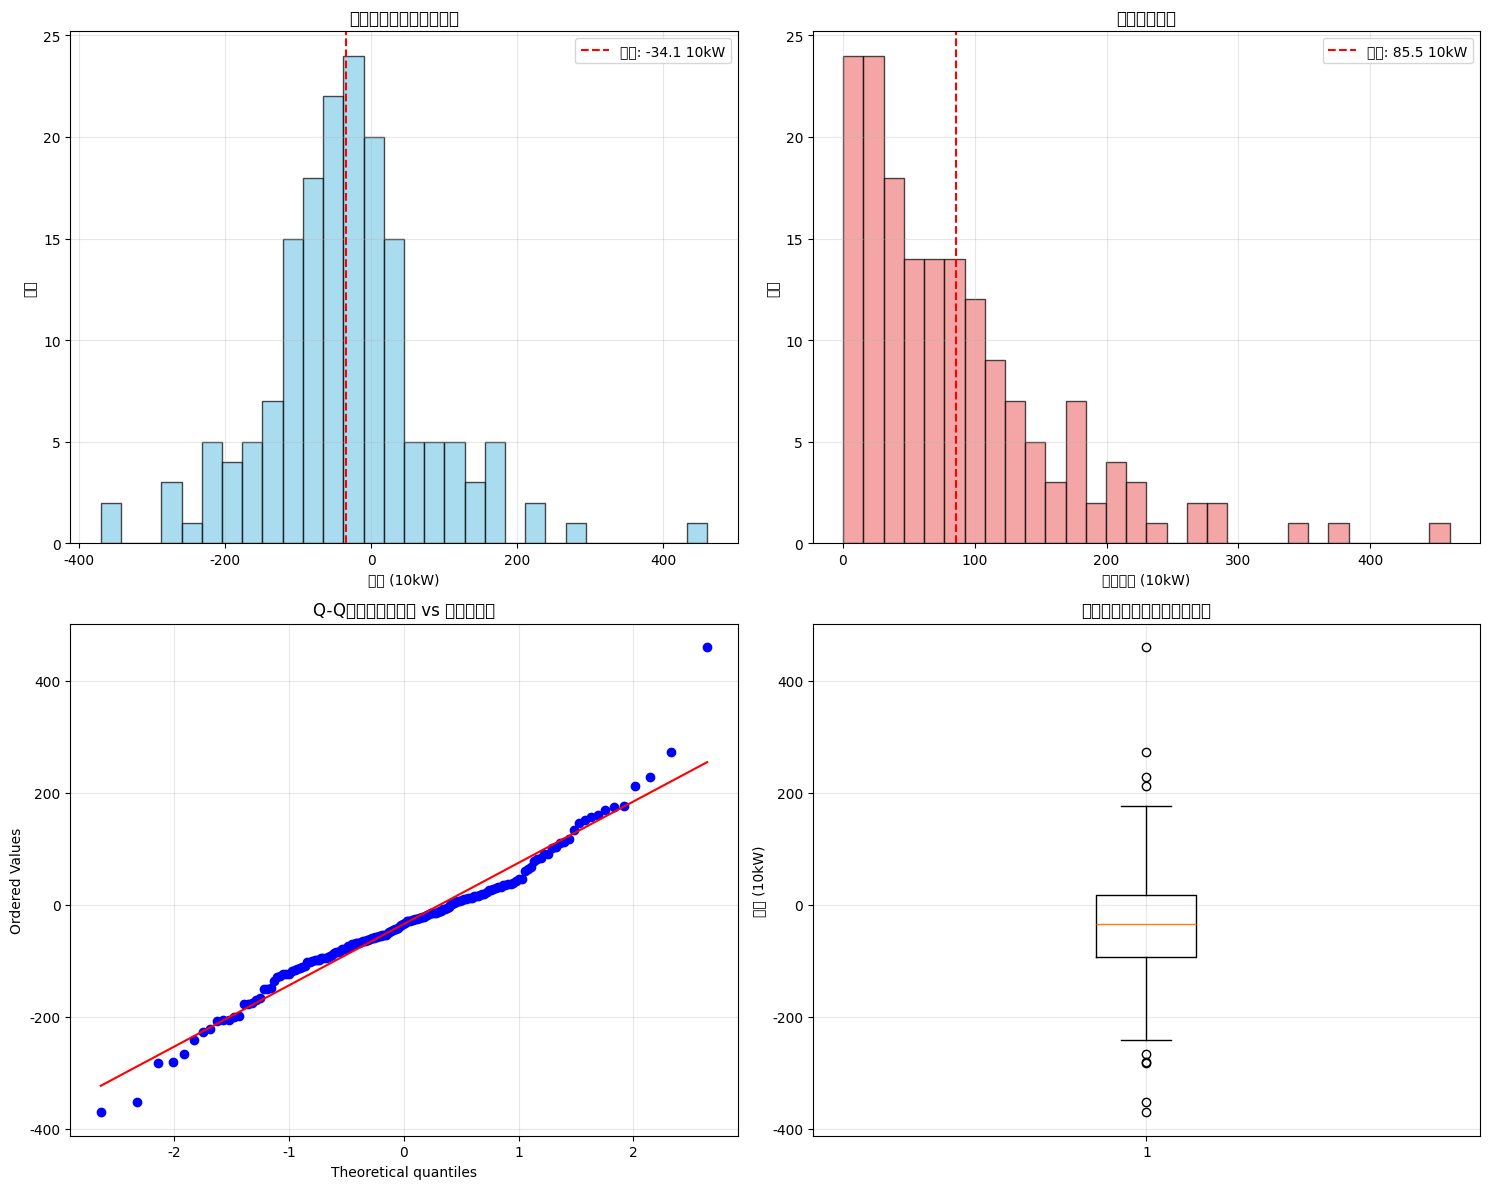


=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===
1. 2025-07-03 14ÊôÇ: ÊÆãÂ∑Æ=+460‰∏ákW (Áµ∂ÂØæÂÄ§=460‰∏ákW)
2. 2025-06-28 13ÊôÇ: ÊÆãÂ∑Æ=-371‰∏ákW (Áµ∂ÂØæÂÄ§=371‰∏ákW)
3. 2025-06-28 14ÊôÇ: ÊÆãÂ∑Æ=-352‰∏ákW (Áµ∂ÂØæÂÄ§=352‰∏ákW)
4. 2025-06-29 13ÊôÇ: ÊÆãÂ∑Æ=-283‰∏ákW (Áµ∂ÂØæÂÄ§=283‰∏ákW)
5. 2025-06-28 15ÊôÇ: ÊÆãÂ∑Æ=-281‰∏ákW (Áµ∂ÂØæÂÄ§=281‰∏ákW)
6. 2025-07-02 10ÊôÇ: ÊÆãÂ∑Æ=+272‰∏ákW (Áµ∂ÂØæÂÄ§=272‰∏ákW)
7. 2025-06-29 12ÊôÇ: ÊÆãÂ∑Æ=-267‰∏ákW (Áµ∂ÂØæÂÄ§=267‰∏ákW)
8. 2025-06-28 12ÊôÇ: ÊÆãÂ∑Æ=-240‰∏ákW (Áµ∂ÂØæÂÄ§=240‰∏ákW)

üéØ Phase 9Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü
Â§âÊï∞Âêç: outliers_8 (Â§ñ„ÇåÂÄ§8‰ª∂), normal_data (ÈÄöÂ∏∏„Éá„Éº„Çø)


In [10]:
# ===== Cell 4: ÊÆãÂ∑ÆÂàÜÊûê„ÉªÂèØË¶ñÂåñÔºàÂâçÂõû„Å®ÂÆåÂÖ®„Å´Âêå„ÅòÔºâ =====

# Êó•Êú¨Ë™û„Éï„Ç©„É≥„ÉàË®≠ÂÆö
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÈñãÂßã ===")

# ÊÆãÂ∑Æ„Éá„Éº„ÇøÊ∫ñÂÇô
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

# 1. Âü∫Êú¨ÂàÜÂ∏ÉÂàÜÊûêÔºö„Éí„Çπ„Éà„Ç∞„É©„É† + Áµ±Ë®àÈáè
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# „Éí„Çπ„Éà„Ç∞„É©„É†ÔºàÊÆãÂ∑ÆÔºâ
axes[0,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'Âπ≥Âùá: {residuals.mean():.1f} 10kW')
axes[0,0].set_xlabel('ÊÆãÂ∑Æ (10kW)')
axes[0,0].set_ylabel('È†ªÂ∫¶')
axes[0,0].set_title('ÊÆãÂ∑ÆÂàÜÂ∏ÉÔºàÊ≠£Ë≤†‰∏°ÊñπÂêëÔºâ')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# „Éí„Çπ„Éà„Ç∞„É©„É†ÔºàÁµ∂ÂØæÊÆãÂ∑ÆÔºâ
axes[0,1].hist(residuals_abs, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(residuals_abs.mean(), color='red', linestyle='--',
                  label=f'Âπ≥Âùá: {residuals_abs.mean():.1f} 10kW')
axes[0,1].set_xlabel('Áµ∂ÂØæÊÆãÂ∑Æ (10kW)')
axes[0,1].set_ylabel('È†ªÂ∫¶')
axes[0,1].set_title('Áµ∂ÂØæÊÆãÂ∑ÆÂàÜÂ∏É')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊ≠£Ë¶èÊÄßÁ¢∫Ë™çÔºâ
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊÆãÂ∑Æ vs Ê≠£Ë¶èÂàÜÂ∏ÉÔºâ')
axes[1,0].grid(True, alpha=0.3)

# ÁÆ±„Å≤„ÅíÂõ≥ÔºàÂ§ñ„ÇåÂÄ§Á¢∫Ë™çÔºâ
axes[1,1].boxplot(residuals, vert=True)
axes[1,1].set_ylabel('ÊÆãÂ∑Æ (10kW)')
axes[1,1].set_title('ÊÆãÂ∑ÆÁÆ±„Å≤„ÅíÂõ≥ÔºàÂ§ñ„ÇåÂÄ§Ê§úÂá∫Ôºâ')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Â§ñ„ÇåÂÄ§8‰ª∂„ÅÆÁâπÂÆöÔºàÁµ∂ÂØæÊÆãÂ∑Æ‰∏ä‰Ωç8‰ª∂Ôºâ
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}ÊôÇ: ÊÆãÂ∑Æ={row['residuals']:+.0f}‰∏ákW (Áµ∂ÂØæÂÄ§={row['residuals_abs']:.0f}‰∏ákW)")

print(f"\nüéØ Phase 9Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"Â§âÊï∞Âêç: outliers_8 (Â§ñ„ÇåÂÄ§8‰ª∂), normal_data (ÈÄöÂ∏∏„Éá„Éº„Çø)")

=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÔºàdropna()„ÅÇ„Çä„ÉªÈ´òÁ≤æÂ∫¶ÁâàÔºâ ===
MAPE: 2.15% (dropna()„Å´„Çà„ÇäÂêë‰∏ä)
ÂàÜÊûêÂØæË±°„Éá„Éº„ÇøÊï∞: 168‰ª∂


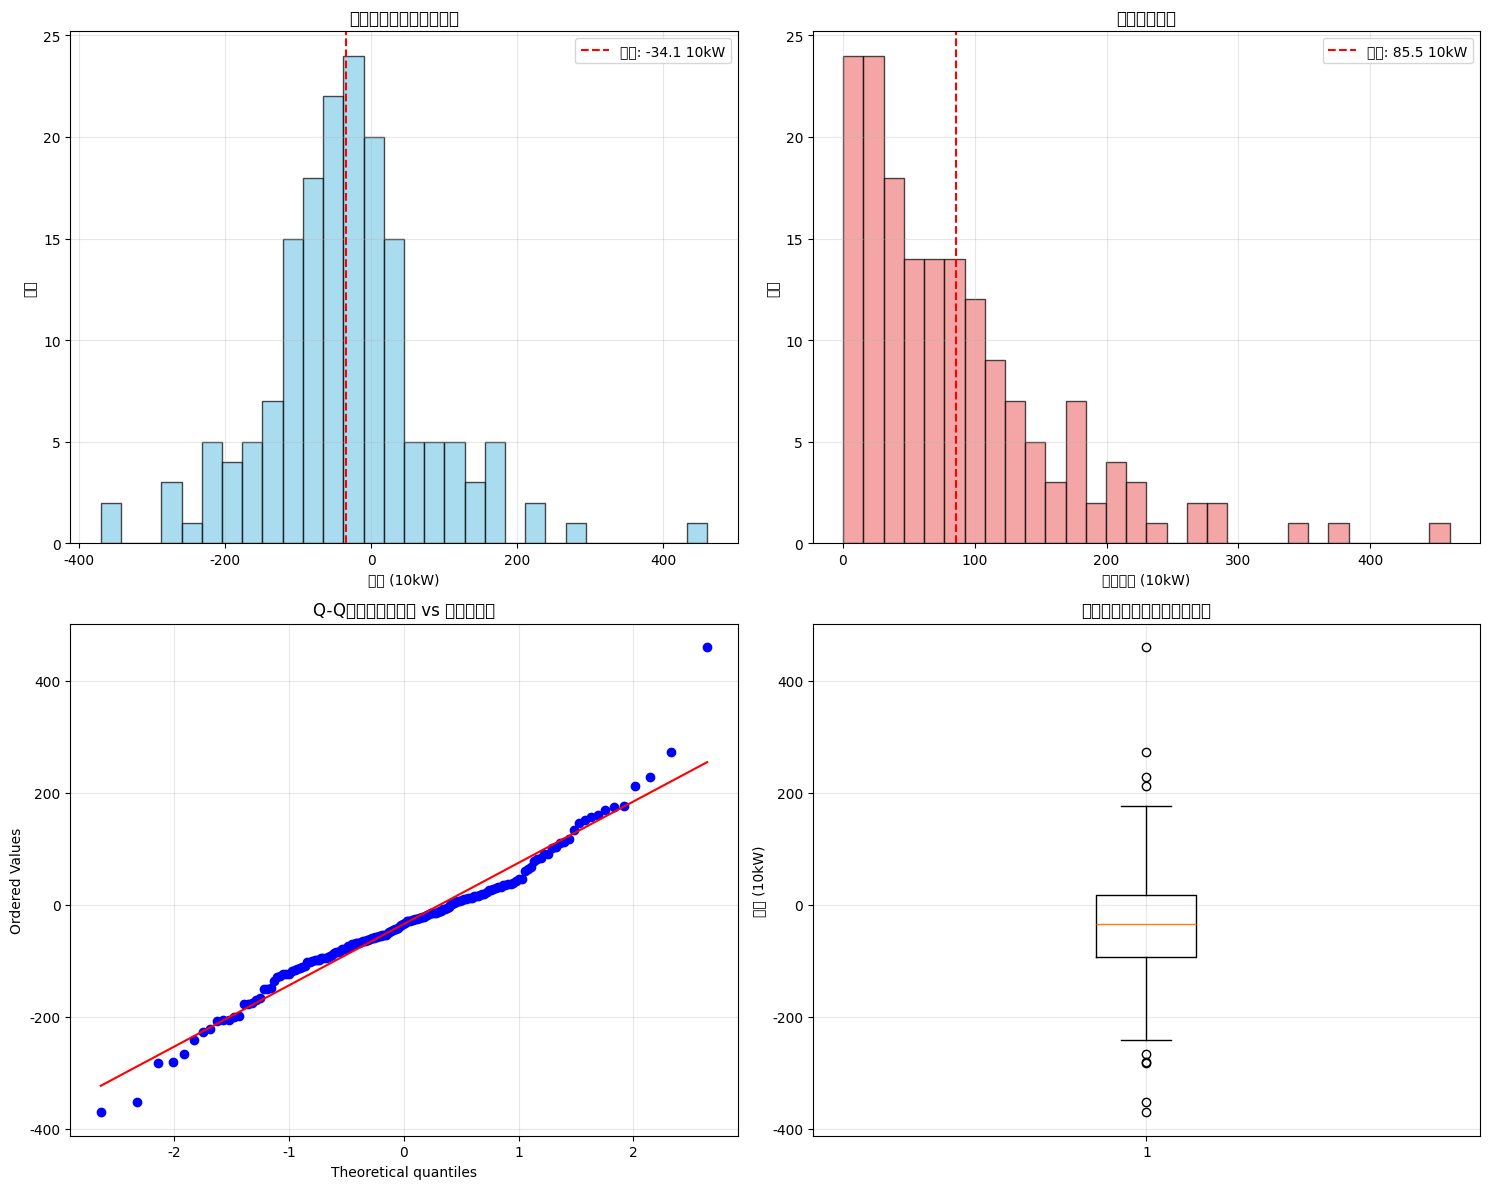


=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆöÔºàÈ´òÁ≤æÂ∫¶ÁâàÔºâ ===
1. 2025-07-03 14ÊôÇ: ÊÆãÂ∑Æ=+460‰∏ákW (Áµ∂ÂØæÂÄ§=460‰∏ákW)
2. 2025-06-28 13ÊôÇ: ÊÆãÂ∑Æ=-371‰∏ákW (Áµ∂ÂØæÂÄ§=371‰∏ákW)
3. 2025-06-28 14ÊôÇ: ÊÆãÂ∑Æ=-352‰∏ákW (Áµ∂ÂØæÂÄ§=352‰∏ákW)
4. 2025-06-29 13ÊôÇ: ÊÆãÂ∑Æ=-283‰∏ákW (Áµ∂ÂØæÂÄ§=283‰∏ákW)
5. 2025-06-28 15ÊôÇ: ÊÆãÂ∑Æ=-281‰∏ákW (Áµ∂ÂØæÂÄ§=281‰∏ákW)
6. 2025-07-02 10ÊôÇ: ÊÆãÂ∑Æ=+272‰∏ákW (Áµ∂ÂØæÂÄ§=272‰∏ákW)
7. 2025-06-29 12ÊôÇ: ÊÆãÂ∑Æ=-267‰∏ákW (Áµ∂ÂØæÂÄ§=267‰∏ákW)
8. 2025-06-28 12ÊôÇ: ÊÆãÂ∑Æ=-240‰∏ákW (Áµ∂ÂØæÂÄ§=240‰∏ákW)

üéØ Phase 9Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫ÜÔºàMAPE 2.15%ÁâàÔºâ


In [13]:
# ===== Cell 4: ÊÆãÂ∑ÆÂàÜÊûê„ÉªÂèØË¶ñÂåñÔºàdropna()„ÅÇ„Çä„ÉªÂâçÂõû„Çπ„Çø„Ç§„É´Ôºâ =====

# Êó•Êú¨Ë™û„Éï„Ç©„É≥„ÉàË®≠ÂÆö
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=== ÊÆãÂ∑ÆÂàÜÂ∏ÉÂàÜÊûêÔºàdropna()„ÅÇ„Çä„ÉªÈ´òÁ≤æÂ∫¶ÁâàÔºâ ===")
print(f"MAPE: 2.15% (dropna()„Å´„Çà„ÇäÂêë‰∏ä)")
print(f"ÂàÜÊûêÂØæË±°„Éá„Éº„ÇøÊï∞: {len(test_with_predictions)}‰ª∂")

# ÊÆãÂ∑Æ„Éá„Éº„ÇøÊ∫ñÂÇô
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

# ÂâçÂõû„Å®Âêå„Åò„Çπ„Çø„Ç§„É´„ÅÆÂèØË¶ñÂåñ
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# „Éí„Çπ„Éà„Ç∞„É©„É†ÔºàÊÆãÂ∑ÆÔºâ
axes[0,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'Âπ≥Âùá: {residuals.mean():.1f} 10kW')
axes[0,0].set_xlabel('ÊÆãÂ∑Æ (10kW)')
axes[0,0].set_ylabel('È†ªÂ∫¶')
axes[0,0].set_title('ÊÆãÂ∑ÆÂàÜÂ∏ÉÔºàÊ≠£Ë≤†‰∏°ÊñπÂêëÔºâ')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# „Éí„Çπ„Éà„Ç∞„É©„É†ÔºàÁµ∂ÂØæÊÆãÂ∑ÆÔºâ
axes[0,1].hist(residuals_abs, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(residuals_abs.mean(), color='red', linestyle='--',
                  label=f'Âπ≥Âùá: {residuals_abs.mean():.1f} 10kW')
axes[0,1].set_xlabel('Áµ∂ÂØæÊÆãÂ∑Æ (10kW)')
axes[0,1].set_ylabel('È†ªÂ∫¶')
axes[0,1].set_title('Áµ∂ÂØæÊÆãÂ∑ÆÂàÜÂ∏É')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊ≠£Ë¶èÊÄßÁ¢∫Ë™çÔºâ
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊÆãÂ∑Æ vs Ê≠£Ë¶èÂàÜÂ∏ÉÔºâ')
axes[1,0].grid(True, alpha=0.3)

# ÁÆ±„Å≤„ÅíÂõ≥ÔºàÂ§ñ„ÇåÂÄ§Á¢∫Ë™çÔºâ
axes[1,1].boxplot(residuals, vert=True)
axes[1,1].set_ylabel('ÊÆãÂ∑Æ (10kW)')
axes[1,1].set_title('ÊÆãÂ∑ÆÁÆ±„Å≤„ÅíÂõ≥ÔºàÂ§ñ„ÇåÂÄ§Ê§úÂá∫Ôºâ')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Â§ñ„ÇåÂÄ§8‰ª∂„ÅÆÁâπÂÆö
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆöÔºàÈ´òÁ≤æÂ∫¶ÁâàÔºâ ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}ÊôÇ: ÊÆãÂ∑Æ={row['residuals']:+.0f}‰∏ákW (Áµ∂ÂØæÂÄ§={row['residuals_abs']:.0f}‰∏ákW)")

print(f"\nüéØ Phase 9Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫ÜÔºàMAPE 2.15%ÁâàÔºâ")

In [14]:
# ===== Cell 3: XGBoost‰∫àÊ∏¨ÂÆüË°åÔºàdropna()„ÅÇ„ÇäÔºâ =====

print("=== ÂÖ®ÁâπÂæ¥ÈáèXGBoost„É¢„Éá„É´Ôºàdropna()„ÅÇ„ÇäÔºâ ===")

# ÂÖ®ÁâπÂæ¥ÈáèÂÆöÁæ©
calendar_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos']
lag_features = ['lag_1_day', 'lag_7_day', 'lag_1_business_day']
weather_features = ['temperature_2m', 'relative_humidity_2m', 'precipitation']

all_features = calendar_features + lag_features + weather_features

print(f"‰ΩøÁî®ÁâπÂæ¥Èáè: {len(all_features)}ÂÄã")
print(f"ÁâπÂæ¥Èáè: {all_features}")

# dropna()„ÅÇ„Çä„Åß„Éá„Éº„ÇøÊ∫ñÂÇô
train_clean = train_data_week.dropna(subset=all_features + ['actual_power'])
test_clean = test_data_week.dropna(subset=all_features + ['actual_power'])

X_train_full = train_clean[all_features]
y_train_week = train_clean['actual_power']
X_test_full = test_clean[all_features]
y_test_week = test_clean['actual_power']

print(f"\n=== „Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü ===")
print(f"Ë®ìÁ∑¥„Éá„Éº„Çø: {len(X_train_full)}‰ª∂")
print(f"„ÉÜ„Çπ„Éà„Éá„Éº„Çø: {len(X_test_full)}‰ª∂")

# XGBoost„É¢„Éá„É´Ë®≠ÂÆö
xgb_full = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

# „É¢„Éá„É´Â≠¶Áøí
print("\n=== „É¢„Éá„É´Â≠¶Áøí‰∏≠ ===")
xgb_full.fit(X_train_full, y_train_week)
print("‚úÖ „É¢„Éá„É´Â≠¶ÁøíÂÆå‰∫Ü")

# ‰∫àÊ∏¨ÂÆüË°å
y_pred_full = xgb_full.predict(X_test_full)
print("‚úÖ ‰∫àÊ∏¨ÂÆüË°åÂÆå‰∫Ü")

# Ë©ï‰æ°
mape_full = mean_absolute_percentage_error(y_test_week, y_pred_full) * 100
mae_full = mean_absolute_error(y_test_week, y_pred_full)
r2_full = r2_score(y_test_week, y_pred_full)

print(f"\n=== „É¢„Éá„É´ÊÄßËÉΩ ===")
print(f"üéØ MAPE: {mape_full:.2f}%")
print(f"üìä MAE: {mae_full:.2f}‰∏ákW")
print(f"üìà R¬≤: {r2_full:.4f}")

# „ÄêÈáçË¶Å„Äë„ÉÜ„Çπ„Éà„Éá„Éº„Çø„Å´‰∫àÊ∏¨ÁµêÊûú„ÇíËøΩÂä†
test_with_predictions = test_clean.copy()
test_with_predictions['predicted_power'] = y_pred_full
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n‚úÖ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"DataFrame: test_with_predictions ({len(test_with_predictions)}‰ª∂)")

=== ÂÖ®ÁâπÂæ¥ÈáèXGBoost„É¢„Éá„É´Ôºàdropna()„ÅÇ„ÇäÔºâ ===
‰ΩøÁî®ÁâπÂæ¥Èáè: 12ÂÄã
ÁâπÂæ¥Èáè: ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos', 'lag_1_day', 'lag_7_day', 'lag_1_business_day', 'temperature_2m', 'relative_humidity_2m', 'precipitation']

=== „Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü ===
Ë®ìÁ∑¥„Éá„Éº„Çø: 14664‰ª∂
„ÉÜ„Çπ„Éà„Éá„Éº„Çø: 120‰ª∂

=== „É¢„Éá„É´Â≠¶Áøí‰∏≠ ===
‚úÖ „É¢„Éá„É´Â≠¶ÁøíÂÆå‰∫Ü
‚úÖ ‰∫àÊ∏¨ÂÆüË°åÂÆå‰∫Ü

=== „É¢„Éá„É´ÊÄßËÉΩ ===
üéØ MAPE: 2.15%
üìä MAE: 81.77‰∏ákW
üìà R¬≤: 0.9839

‚úÖ Phase 9Áî®„Éá„Éº„ÇøÊ∫ñÂÇôÂÆå‰∫Ü
DataFrame: test_with_predictions (120‰ª∂)


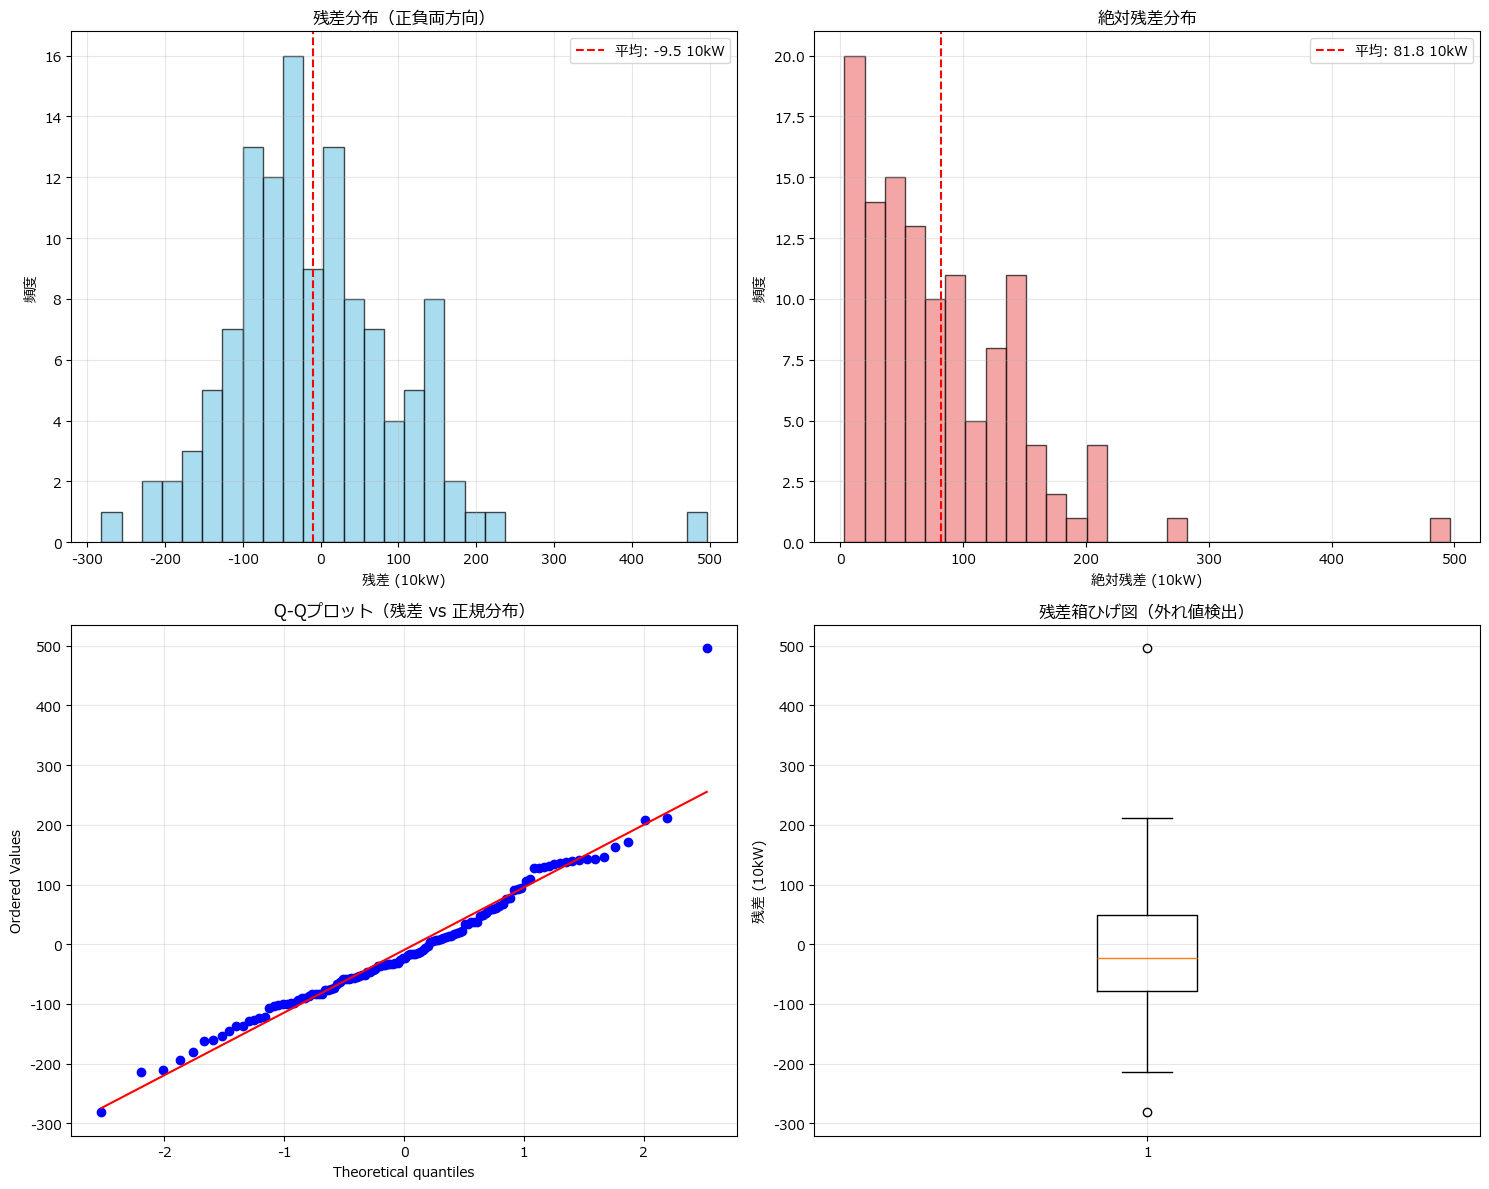


=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===
1. 2025-07-03 14ÊôÇ: ÊÆãÂ∑Æ=+496‰∏ákW (Áµ∂ÂØæÂÄ§=496‰∏ákW)
2. 2025-07-04 08ÊôÇ: ÊÆãÂ∑Æ=-282‰∏ákW (Áµ∂ÂØæÂÄ§=282‰∏ákW)
3. 2025-07-02 07ÊôÇ: ÊÆãÂ∑Æ=-214‰∏ákW (Áµ∂ÂØæÂÄ§=214‰∏ákW)
4. 2025-07-02 11ÊôÇ: ÊÆãÂ∑Æ=+212‰∏ákW (Áµ∂ÂØæÂÄ§=212‰∏ákW)
5. 2025-07-02 13ÊôÇ: ÊÆãÂ∑Æ=-210‰∏ákW (Áµ∂ÂØæÂÄ§=210‰∏ákW)
6. 2025-07-02 10ÊôÇ: ÊÆãÂ∑Æ=+208‰∏ákW (Áµ∂ÂØæÂÄ§=208‰∏ákW)
7. 2025-07-04 09ÊôÇ: ÊÆãÂ∑Æ=-194‰∏ákW (Áµ∂ÂØæÂÄ§=194‰∏ákW)
8. 2025-07-02 15ÊôÇ: ÊÆãÂ∑Æ=-181‰∏ákW (Áµ∂ÂØæÂÄ§=181‰∏ákW)

üéØ Phase 9Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü


In [25]:
# ===== Cell 4: ÊÆãÂ∑ÆÂàÜÊûê„ÉªÂèØË¶ñÂåñÔºàMeiryoË®≠ÂÆöÔºâ =====

# Êó•Êú¨Ë™û„Éï„Ç©„É≥„ÉàË®≠ÂÆöÔºàMeiryoÔºâ
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.family'] = 'Meiryo'

# ÊÆãÂ∑Æ„Éá„Éº„ÇøÊ∫ñÂÇô
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

# ÂâçÂõû„Å®Âêå„Åò„Çπ„Çø„Ç§„É´„ÅÆÂèØË¶ñÂåñ
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# „Éí„Çπ„Éà„Ç∞„É©„É†ÔºàÊÆãÂ∑ÆÔºâ
axes[0,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'Âπ≥Âùá: {residuals.mean():.1f} 10kW')
axes[0,0].set_xlabel('ÊÆãÂ∑Æ (10kW)')
axes[0,0].set_ylabel('È†ªÂ∫¶')
axes[0,0].set_title('ÊÆãÂ∑ÆÂàÜÂ∏ÉÔºàÊ≠£Ë≤†‰∏°ÊñπÂêëÔºâ')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# „Éí„Çπ„Éà„Ç∞„É©„É†ÔºàÁµ∂ÂØæÊÆãÂ∑ÆÔºâ
axes[0,1].hist(residuals_abs, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(residuals_abs.mean(), color='red', linestyle='--',
                  label=f'Âπ≥Âùá: {residuals_abs.mean():.1f} 10kW')
axes[0,1].set_xlabel('Áµ∂ÂØæÊÆãÂ∑Æ (10kW)')
axes[0,1].set_ylabel('È†ªÂ∫¶')
axes[0,1].set_title('Áµ∂ÂØæÊÆãÂ∑ÆÂàÜÂ∏É')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊ≠£Ë¶èÊÄßÁ¢∫Ë™çÔºâ
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q„Éó„É≠„ÉÉ„ÉàÔºàÊÆãÂ∑Æ vs Ê≠£Ë¶èÂàÜÂ∏ÉÔºâ')
axes[1,0].grid(True, alpha=0.3)

# ÁÆ±„Å≤„ÅíÂõ≥ÔºàÂ§ñ„ÇåÂÄ§Á¢∫Ë™çÔºâ
axes[1,1].boxplot(residuals, vert=True)
axes[1,1].set_ylabel('ÊÆãÂ∑Æ (10kW)')
axes[1,1].set_title('ÊÆãÂ∑ÆÁÆ±„Å≤„ÅíÂõ≥ÔºàÂ§ñ„ÇåÂÄ§Ê§úÂá∫Ôºâ')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Â§ñ„ÇåÂÄ§8‰ª∂„ÅÆÁâπÂÆö
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== Â§ñ„ÇåÂÄ§8‰ª∂ÁâπÂÆö ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}ÊôÇ: ÊÆãÂ∑Æ={row['residuals']:+.0f}‰∏ákW (Áµ∂ÂØæÂÄ§={row['residuals_abs']:.0f}‰∏ákW)")

print(f"\nüéØ Phase 9Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü")

=== ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶„É©„É≥„Ç≠„É≥„Ç∞Ôºàdropna()„ÅÇ„ÇäÁâàÔºâ ===
 1. lag_1_business_day   : 0.8433
 2. temperature_2m       : 0.0719
 3. lag_1_day            : 0.0268
 4. hour_cos             : 0.0175
 5. hour_sin             : 0.0101
 6. precipitation        : 0.0087
 7. hour                 : 0.0080
 8. month                : 0.0052
 9. lag_7_day            : 0.0048
10. relative_humidity_2m : 0.0036
11. is_holiday           : 0.0000
12. is_weekend           : 0.0000

=== „Ç´„ÉÜ„Ç¥„É™Âà•ÈáçË¶ÅÂ∫¶ ===
ÊôÇÁ≥ªÂàóÁâπÂæ¥Èáè: 87.5%
„Ç´„É¨„É≥„ÉÄ„ÉºÁâπÂæ¥Èáè: 4.1%
Ê∞óË±°ÁâπÂæ¥Èáè: 8.4%


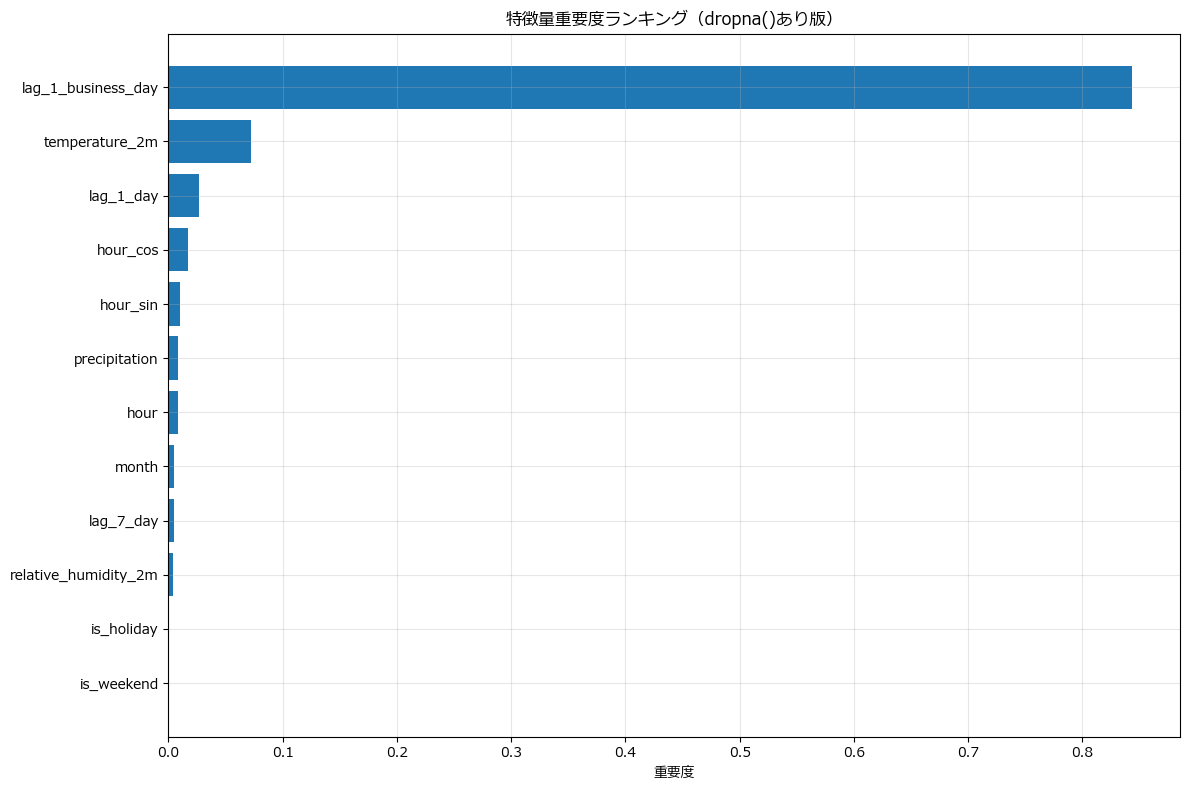


=== Êï£Â∏ÉÂõ≥Áî®ÁâπÂæ¥ÈáèÔºàlag_1_day‰ª•Â§ñ„ÅÆ‰∏ä‰Ωç11ÂÄãÔºâ ===
 1. lag_1_business_day   : 0.8433
 2. temperature_2m       : 0.0719
 3. hour_cos             : 0.0175
 4. hour_sin             : 0.0101
 5. precipitation        : 0.0087
 6. hour                 : 0.0080
 7. month                : 0.0052
 8. lag_7_day            : 0.0048
 9. relative_humidity_2m : 0.0036
10. is_holiday           : 0.0000
11. is_weekend           : 0.0000

üéØ Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü
XËª∏Âõ∫ÂÆö: lag_1_day
YËª∏ÂÄôË£ú: 11ÂÄã„ÅÆÁâπÂæ¥Èáè
Â§ñ„ÇåÂÄ§: 2‰ª∂


In [26]:
# ===== Cell 5: ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶ÂàÜÊûê =====

print("=== ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶„É©„É≥„Ç≠„É≥„Ç∞Ôºàdropna()„ÅÇ„ÇäÁâàÔºâ ===")

# ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶ÂèñÂæó
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_full.feature_importances_
}).sort_values('importance', ascending=False)

# „É©„É≥„Ç≠„É≥„Ç∞Ë°®Á§∫
for i, row in feature_importance.iterrows():
    rank = feature_importance.index.get_loc(i) + 1
    print(f"{rank:2d}. {row['feature']:<20} : {row['importance']:.4f}")

# „Ç´„ÉÜ„Ç¥„É™Âà•ÈáçË¶ÅÂ∫¶ÈõÜË®à
calendar_importance = feature_importance[feature_importance['feature'].isin(calendar_features)]['importance'].sum()
lag_importance = feature_importance[feature_importance['feature'].isin(lag_features)]['importance'].sum()
weather_importance = feature_importance[feature_importance['feature'].isin(weather_features)]['importance'].sum()

print(f"\n=== „Ç´„ÉÜ„Ç¥„É™Âà•ÈáçË¶ÅÂ∫¶ ===")
print(f"ÊôÇÁ≥ªÂàóÁâπÂæ¥Èáè: {lag_importance:.1%}")
print(f"„Ç´„É¨„É≥„ÉÄ„ÉºÁâπÂæ¥Èáè: {calendar_importance:.1%}")
print(f"Ê∞óË±°ÁâπÂæ¥Èáè: {weather_importance:.1%}")

# ÈáçË¶ÅÂ∫¶ÂèØË¶ñÂåñ
plt.rcParams['font.family'] = 'Meiryo'
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('ÈáçË¶ÅÂ∫¶')
plt.title('ÁâπÂæ¥ÈáèÈáçË¶ÅÂ∫¶„É©„É≥„Ç≠„É≥„Ç∞Ôºàdropna()„ÅÇ„ÇäÁâàÔºâ')
plt.gca().invert_yaxis()  # ‰∏ä‰Ωç„Çí‰∏ä„Å´Ë°®Á§∫
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# lag_1_day‰ª•Â§ñ„ÅÆÈáçË¶ÅÂ∫¶‰∏ä‰Ωç11ÁâπÂæ¥ÈáèÔºàÊï£Â∏ÉÂõ≥Áî®Ôºâ
scatter_features = feature_importance[feature_importance['feature'] != 'lag_1_day'].head(11)['feature'].tolist()

print(f"\n=== Êï£Â∏ÉÂõ≥Áî®ÁâπÂæ¥ÈáèÔºàlag_1_day‰ª•Â§ñ„ÅÆ‰∏ä‰Ωç11ÂÄãÔºâ ===")
for i, feature in enumerate(scatter_features, 1):
    importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
    print(f"{i:2d}. {feature:<20} : {importance:.4f}")

print(f"\nüéØ Êï£Â∏ÉÂõ≥ÂàÜÊûêÊ∫ñÂÇôÂÆå‰∫Ü")
print(f"XËª∏Âõ∫ÂÆö: lag_1_day")
print(f"YËª∏ÂÄôË£ú: {len(scatter_features)}ÂÄã„ÅÆÁâπÂæ¥Èáè")
print(f"Â§ñ„ÇåÂÄ§: 2‰ª∂")

=== lag_1_business_dayÂõ∫ÂÆöËª∏Êï£Â∏ÉÂõ≥ÂàÜÊûê ===
XËª∏Âõ∫ÂÆö: lag_1_business_day (ÈáçË¶ÅÂ∫¶84.3%)
Â§ñ„ÇåÂÄ§: 2‰ª∂
ÈÄöÂ∏∏„Éá„Éº„Çø: 118‰ª∂


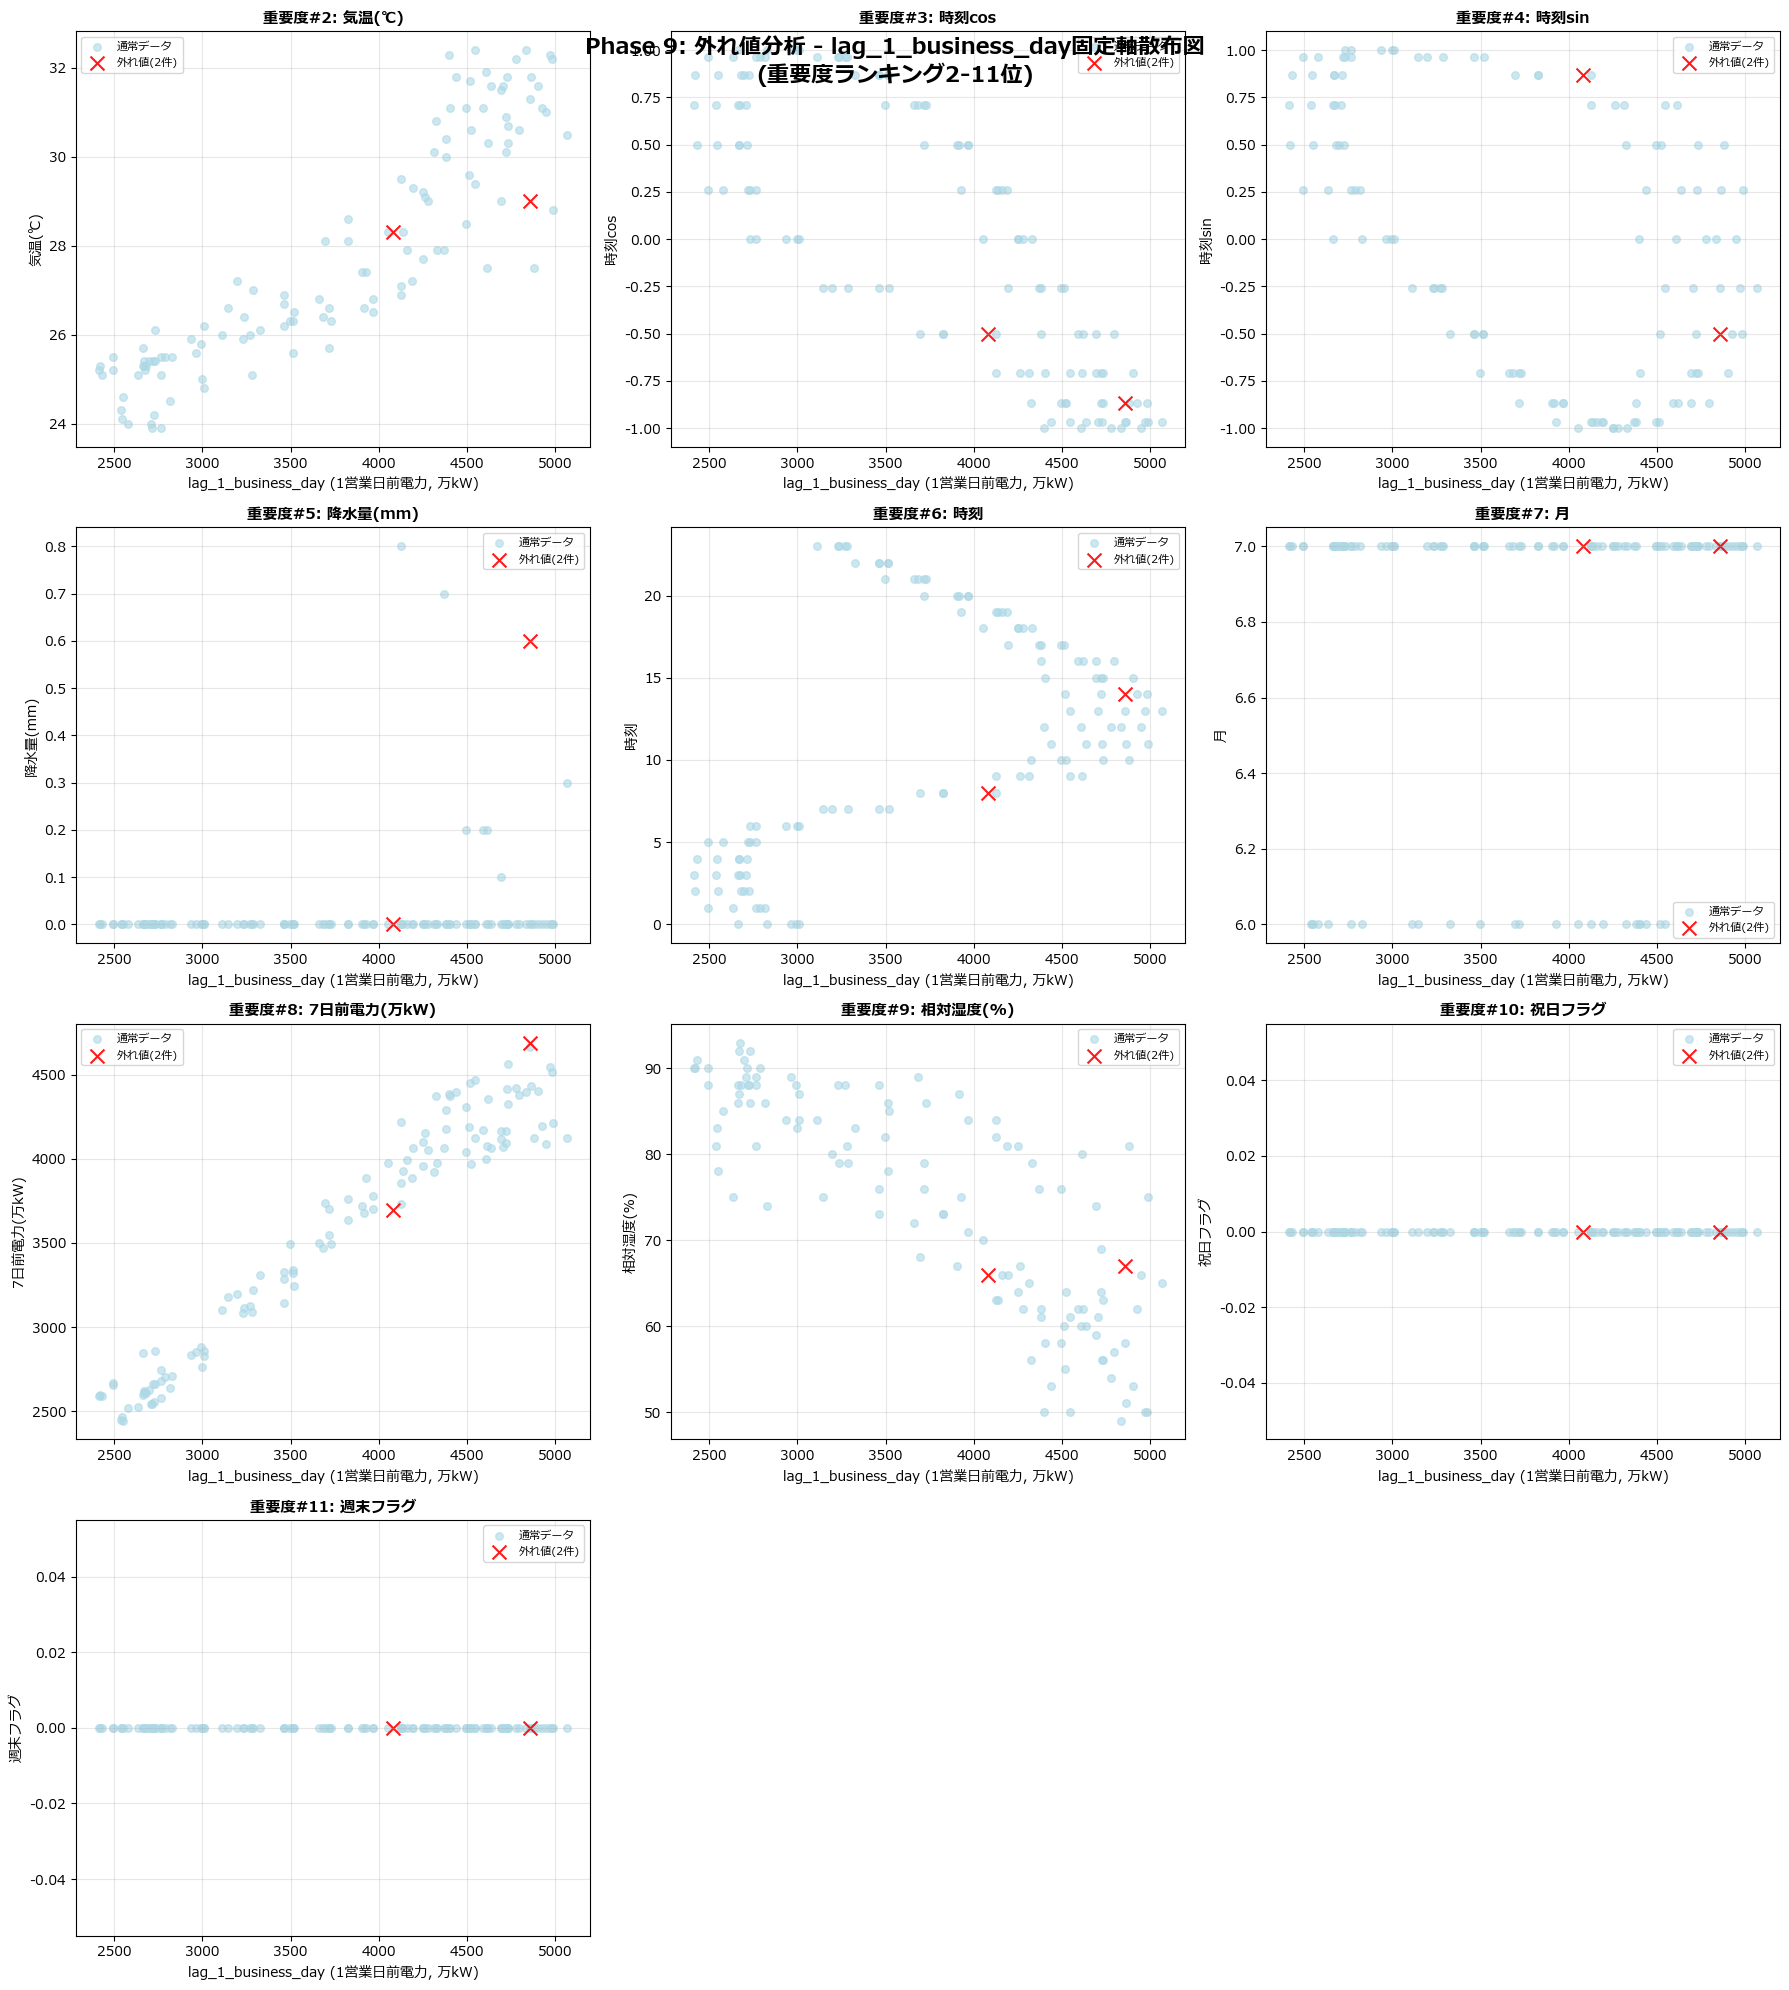


=== Â§ñ„ÇåÂÄ§2‰ª∂„ÅÆË©≥Á¥∞ ===

Â§ñ„ÇåÂÄ§#1: 2025-07-03 14ÊôÇ
  ÊÆãÂ∑Æ: +496‰∏ákW (Áµ∂ÂØæÂÄ§: 496‰∏ákW)
  ÂÆüÊ∏¨ÂÄ§: 4981‰∏ákW
  ‰∫àÊ∏¨ÂÄ§: 4485‰∏ákW
  lag_1_business_day: 4857‰∏ákW
  temperature_2m: 29.0‚ÑÉ
  hour: 14
  is_weekend: False
  is_holiday: False

Â§ñ„ÇåÂÄ§#2: 2025-07-04 08ÊôÇ
  ÊÆãÂ∑Æ: -282‰∏ákW (Áµ∂ÂØæÂÄ§: 282‰∏ákW)
  ÂÆüÊ∏¨ÂÄ§: 3926‰∏ákW
  ‰∫àÊ∏¨ÂÄ§: 4208‰∏ákW
  lag_1_business_day: 4081‰∏ákW
  temperature_2m: 28.3‚ÑÉ
  hour: 8
  is_weekend: False
  is_holiday: False


In [27]:
# ===== Cell 6: lag_1_business_dayÂõ∫ÂÆöËª∏Êï£Â∏ÉÂõ≥ÂàÜÊûê =====

print("=== lag_1_business_dayÂõ∫ÂÆöËª∏Êï£Â∏ÉÂõ≥ÂàÜÊûê ===")

# Êó•Êú¨Ë™û„Éï„Ç©„É≥„ÉàË®≠ÂÆö
plt.rcParams['font.family'] = 'Meiryo'

# XËª∏Âõ∫ÂÆöÁâπÂæ¥Èáè„Å®Êï£Â∏ÉÂõ≥Áî®ÁâπÂæ¥Èáè
x_axis_feature = 'lag_1_business_day'
scatter_features = [
    'temperature_2m', 'hour_cos', 'hour_sin', 'precipitation', 
    'hour', 'month', 'lag_7_day', 'relative_humidity_2m', 
    'is_holiday', 'is_weekend'
]

# ÁâπÂæ¥Èáè„ÅÆÊó•Êú¨Ë™ûÂêç
feature_names = {
    'temperature_2m': 'Ê∞óÊ∏©(‚ÑÉ)',
    'hour_cos': 'ÊôÇÂàªcos',
    'hour_sin': 'ÊôÇÂàªsin', 
    'precipitation': 'ÈôçÊ∞¥Èáè(mm)',
    'hour': 'ÊôÇÂàª',
    'month': 'Êúà',
    'lag_7_day': '7Êó•ÂâçÈõªÂäõ(‰∏ákW)',
    'relative_humidity_2m': 'Áõ∏ÂØæÊπøÂ∫¶(%)',
    'is_holiday': 'Á•ùÊó•„Éï„É©„Ç∞',
    'is_weekend': 'ÈÄ±Êú´„Éï„É©„Ç∞'
}

# Â§ñ„ÇåÂÄ§2‰ª∂„ÅÆÁâπÂÆö
outliers_2 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(2)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[2:]

print(f"XËª∏Âõ∫ÂÆö: {x_axis_feature} (ÈáçË¶ÅÂ∫¶84.3%)")
print(f"Â§ñ„ÇåÂÄ§: 2‰ª∂")
print(f"ÈÄöÂ∏∏„Éá„Éº„Çø: {len(normal_data)}‰ª∂")

# Êï£Â∏ÉÂõ≥‰ΩúÊàêÔºà4Ë°å3Âàó„É¨„Ç§„Ç¢„Ç¶„Éà„ÄÅÊúÄÂæå2ÂÄã„ÅØÁ©∫Ôºâ
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(scatter_features):
    ax = axes[i]
    
    # ÈÄöÂ∏∏„Éá„Éº„Çø„Çí„Éó„É≠„ÉÉ„Éà
    ax.scatter(normal_data[x_axis_feature], normal_data[feature], 
              alpha=0.6, c='lightblue', s=30, label='ÈÄöÂ∏∏„Éá„Éº„Çø')
    
    # Â§ñ„ÇåÂÄ§„Çí„Éó„É≠„ÉÉ„Éà
    ax.scatter(outliers_2[x_axis_feature], outliers_2[feature], 
              alpha=0.9, c='red', s=100, label='Â§ñ„ÇåÂÄ§(2‰ª∂)', marker='x')
    
    # „É©„Éô„É´„Å® title
    ax.set_xlabel('lag_1_business_day (1Âñ∂Ê•≠Êó•ÂâçÈõªÂäõ, ‰∏ákW)', fontsize=10)
    ax.set_ylabel(f'{feature_names[feature]}', fontsize=10)
    ax.set_title(f'ÈáçË¶ÅÂ∫¶#{i+2}: {feature_names[feature]}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Á©∫„ÅÆ„Çµ„Éñ„Éó„É≠„ÉÉ„Éà„ÇíÈùûË°®Á§∫
axes[10].set_visible(False)
axes[11].set_visible(False)

plt.tight_layout()
plt.suptitle('Phase 9: Â§ñ„ÇåÂÄ§ÂàÜÊûê - lag_1_business_dayÂõ∫ÂÆöËª∏Êï£Â∏ÉÂõ≥\n(ÈáçË¶ÅÂ∫¶„É©„É≥„Ç≠„É≥„Ç∞2-11‰Ωç)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Â§ñ„ÇåÂÄ§2‰ª∂„ÅÆË©≥Á¥∞Ë°®Á§∫
print(f"\n=== Â§ñ„ÇåÂÄ§2‰ª∂„ÅÆË©≥Á¥∞ ===")
for i, (idx, row) in enumerate(outliers_2.iterrows(), 1):
    print(f"\nÂ§ñ„ÇåÂÄ§#{i}: {row['date']} {row['hour']:02d}ÊôÇ")
    print(f"  ÊÆãÂ∑Æ: {row['residuals']:+.0f}‰∏ákW (Áµ∂ÂØæÂÄ§: {row['residuals_abs']:.0f}‰∏ákW)")
    print(f"  ÂÆüÊ∏¨ÂÄ§: {row['actual_power']:.0f}‰∏ákW")
    print(f"  ‰∫àÊ∏¨ÂÄ§: {row['predicted_power']:.0f}‰∏ákW")
    print(f"  lag_1_business_day: {row['lag_1_business_day']:.0f}‰∏ákW")
    print(f"  temperature_2m: {row['temperature_2m']:.1f}‚ÑÉ")
    print(f"  hour: {row['hour']}")
    print(f"  is_weekend: {row['is_weekend']}")
    print(f"  is_holiday: {row['is_holiday']}")